# Преобразование Фурье

In [ ]:
import math
import time

import numpy as np
import numpy.fft as npf

from scipy import stats as sps
from scipy import fft as spf
from scipy.integrate import quad

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import numba

from tqdm import tqdm

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

## Дискретное преобразование Фурье



### Вывод дискретного проеброзования Фурье

Рассмотрим некоторый периодический сигнал $x(t)$ c периодом, равным $T$. Разложим сигнал в ряд Фурье:
$$
x(t) = \sum^{+\infty}_{k =-\infty} c_k e^{i \frac{2 \pi k}{T}  t}
$$

Дискретизируем сигнал так, чтобы на периоде было N отсчетов: $ \{t_n \}_{n  = 0}^{N-1} = \{ \frac{n}{N}T \}_{n = 0}^{N-1}$. Тогда ряд проеброзуется в:
$$
x_n = x(t_n) = \sum^{+\infty}_{k =-\infty} c_k e^{\frac{2 \pi i}{N}  kn}
$$

Заметим, что $e^{\frac{2 \pi i}{N} (k + mN)n} = e^{\frac{2 \pi i}{N} kn}$. Тогда запись ряда можно сократить:
$$
x_n = \sum_{k = 0}^{N-1} X_k e^{\frac{2 \pi i}{N} kn}, \ \ \text{где} \ \ X_k = \sum_{m = -\infty}^{+\infty} c_{k + mN}
$$

Получили обратное преобразование Фурье. Получение прямого преобразование Фурье опустим:
$$
X_n = \frac{1}{N} \sum_{k = 0}^{N-1} x_k e^{-\frac{2 \pi i}{N} kn}
$$

У этой модели есть проблемы:
1. Если у сигнала наибольшая значимая гармоника соответствует индексу $M$, а мы дискретизируем промежуток $[0,T)$ с числом отсчётов $N < M$, то при дискретизации происходит потеря информации об исходном сигнале. (проблема Алиасинга)

### Реализация дискретного преобразования Фурье (прямого и обратного)

In [ ]:
def DFT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    @numba.jit
    def _calc(X):
        for k in range(N):
            for n in range(N):
                X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)

    _calc(X)
    return X

def IDFT(X):
    N = len(X)
    y = np.zeros(N, dtype=complex)

    @numba.jit
    def _calc(y):
        for m in range(N):
            for k in range(N):
                y[m] += X[k] * np.exp(2j * np.pi * k * m / N)
            y[m] /= N

    _calc(y)
    return y.real


# numba compilation
DFT(np.arange(10))
IDFT(np.arange(10));

### Реализация быстрого дискретного преобразования Фурье (прямого и обратного)

In [ ]:
# @numba.jit(nopython=True)
# def bit_reverse(x):
#     N = x.shape[0]
#     j = 0
#     for i in range(N):
#         if i < j:
#             x[i], x[j] = x[j], x[i]
#         bit = N >> 1
#         while j & bit:
#             j ^= bit
#             bit >>= 1
#         j |= bit

# @numba.jit(nopython=True)
# def fft_inplace(x):
#     N = x.shape[0]
#     bit_reverse(x)
#     m = 2
#     while m <= N:
#         theta = -2j * np.pi / m
#         w_m = np.exp(theta)
#         for k in range(0, N, m):
#             w = 1+0j
#             for j in range(m // 2):
#                 t = w * x[k + j + m // 2]
#                 u = x[k + j]
#                 x[k + j] = u + t
#                 x[k + j + m // 2] = u - t
#                 w *= w_m
#         m *= 2

# @numba.jit(nopython=True)
# def ifft_inplace(x):
#     N = x.shape[0]
#     for i in range(N):
#         x[i] = np.conj(x[i])
#     fft_inplace(x)
#     for i in range(N):
#         x[i] = np.conj(x[i]) / N

# def FFT(x):
#     N = x.shape[0]
#     X = np.array(x, dtype=np.complex128)
#     fft_inplace(X)
#     return X

# def IFFT(X):
#     x = np.array(X, dtype=np.complex128)
#     ifft_inplace(x)
#     return x.real

# # numba compilation
# FFT(np.arange(10))
# IFFT(np.arange(10));

### Нахождение спектра у сигналов

#### Полезные классы/функции

класс `Signal` для удобства.

In [201]:
class Signal:
    """
    Сигнал как сумма конечного числа гармоник.
    Поддерживаются два способа задания:
      1. Экспоненциальные коэффициенты f_n (словарь {n: f_n}).
      2. Коэффициенты косинусов и синусов a_0, a_n, b_n (словари).
    """

    def __init__(
        self,
        exp_coeffs=None,
        sin_coeffs=None,
        cos_coeffs=None,
        base=None,
        period=2 * np.pi,
    ):
        self.T = period
        self.an = np.array([])
        self.bn = np.array([])

        if exp_coeffs is not None:
            n = max(map(abs, exp_coeffs.keys()))
            self.n = n
            self.a0 = 2 * exp_coeffs.get(0, 0).real
            self.an = np.array(
                [
                    exp_coeffs.get(k, 0).real + exp_coeffs.get(-k, 0).real
                    for k in range(1, n + 1)
                ]
            )
            self.bn = np.array(
                [
                    (exp_coeffs.get(k, 0).imag - exp_coeffs.get(-k, 0).imag)
                    for k in range(1, n + 1)
                ]
            )
        elif (sin_coeffs is not None) and (cos_coeffs is not None):
            n = max(
                max(sin_coeffs.keys(), default=0), max(cos_coeffs.keys(), default=0)
            )
            self.n = n
            self.an = np.array([cos_coeffs.get(k, 0) for k in range(1, n + 1)])
            self.bn = np.array([sin_coeffs.get(k, 0) for k in range(1, n + 1)])
            self.a0 = 0 if base is None else base
        else:
            raise ValueError(
                "exp_coeffs or (sin_coeffs, cos_coeffs, base) must be provided"
            )

        self.fn_pos = (self.an - 1j * self.bn) / 2
        self.fn_neg = (self.an + 1j * self.bn) / 2

        ks_pos = np.arange(1, self.n + 1)
        ks_neg = -ks_pos
        self.ks = np.concatenate(([0], ks_pos, ks_neg))
        self.cs = np.concatenate(([self.a0], self.fn_pos, self.fn_neg))

    @classmethod
    def from_exp(cls, exp_coeffs, period=2 * np.pi):
        return cls(exp_coeffs=exp_coeffs, period=period)

    @classmethod
    def from_sin_cos(cls, sin_coeffs, cos_coeffs, base=None, period=2 * np.pi):
        return cls(
            sin_coeffs=sin_coeffs, cos_coeffs=cos_coeffs, base=base, period=period
        )

    def get_exp_coeffs(self):
        """Возвращает словарь экспоненциальных коэффициентов f_n"""
        return {k: c for k, c in zip(self.ks, self.cs)}

    def get_sin_cos_coeffs(self):
        """Возвращает (a0, an, bn)"""
        return self.a0, self.an, self.bn

    def value(self, t):
        """Вычислить значение сигнала в точках t"""
        t = np.asarray(t)
        exponent = np.exp(2j * np.pi * np.outer(self.ks, t) / self.T)  # shape: (K, T)
        result = np.dot(self.cs, exponent)  # shape: (T,)
        return result.real if np.allclose(result.imag, 0, atol=1e-12) else result

    def discretize(self, N):
        """Дискретизировать сигнал на N отсчетов по одному периоду"""
        t_n = np.linspace(0, self.T, N, endpoint=False)
        x_n = self.value(t_n)
        return t_n, x_n

Функция для визуализации спектра сигнала

In [207]:
def plot_fourier_spectra(x, X, N, period, figsize=(15, 10), plot_sin_cos=True):
    """
    Рисует 4 графика:
    - сигнал + восстановленный сигнал (сравнение, mse, max error)
    - спектр по экспонентам (амплитудный)
    - спектр по косинусам (a_n)
    - спектр по синусам (b_n)
    """
    x_recon = IDFT(X)
    mse = np.mean((x - x_recon) ** 2)
    max_err = np.max(np.abs(x - x_recon))

    X = X / N
    t = np.linspace(0, period, N)

    k = np.arange(N)
    freqs = np.fft.fftfreq(N, d=period / N)

    f_n = X
    f_shifted = np.fft.fftshift(f_n)
    freqs_shifted = np.fft.fftshift(freqs)

    half = N // 2
    a_n = 2 * f_n[1:half].real
    b_n = -2 * f_n[1:half].imag
    harmonics = np.arange(1, half)

    rows = 2 if plot_sin_cos else 1
    figsize = (figsize[0], figsize[1])
    fig, axs = plt.subplots(rows, 2, figsize=figsize)
    axs = np.atleast_2d(axs)

    # === Исходный и восстановленный сигнал ===
    axs[0, 0].plot(t, x, label="Оригинал", lw=2)
    axs[0, 0].plot(t, x_recon, "--", label="Восстановленный", lw=2)
    axs[0, 0].set_title("Сигнал (сравнение)")
    axs[0, 0].set_xlabel("Время")
    axs[0, 0].legend(loc=1)
    axs[0, 0].grid(True)
    axs[0, 0].text(
        0.05,
        0.95,
        f"MSE = {mse:.2e}\nMax error = {max_err:.2e}",
        transform=axs[0, 0].transAxes,
        verticalalignment="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    # === Амплитудный спектр ===
    axs[0, 1].stem(freqs_shifted, np.abs(f_shifted), basefmt=" ")
    axs[0, 1].set_title(r"Апмлитудный спектр $|f_n|$")
    axs[0, 1].set_xlabel("Частота, n")
    axs[0, 1].grid(True)

    if plot_sin_cos:
        # === Косинусные коэффициенты ===
        axs[1, 0].stem(harmonics, a_n, basefmt=" ")
        axs[1, 0].set_title(r"Косинусные коэффициенты $a_n$")
        axs[1, 0].set_xlabel("Частота, n")
        axs[1, 0].grid(True)

        # === Синусные коэффициенты ===
        axs[1, 1].stem(harmonics, b_n, basefmt=" ")
        axs[1, 1].set_title(r"Синусные коэффициенты $b_n$")
        axs[1, 1].set_xlabel("Частота, n")
        axs[1, 1].grid(True)

    plt.tight_layout()
    return fig, axs

#### Простой сигнал: сумма синуса и косинуса

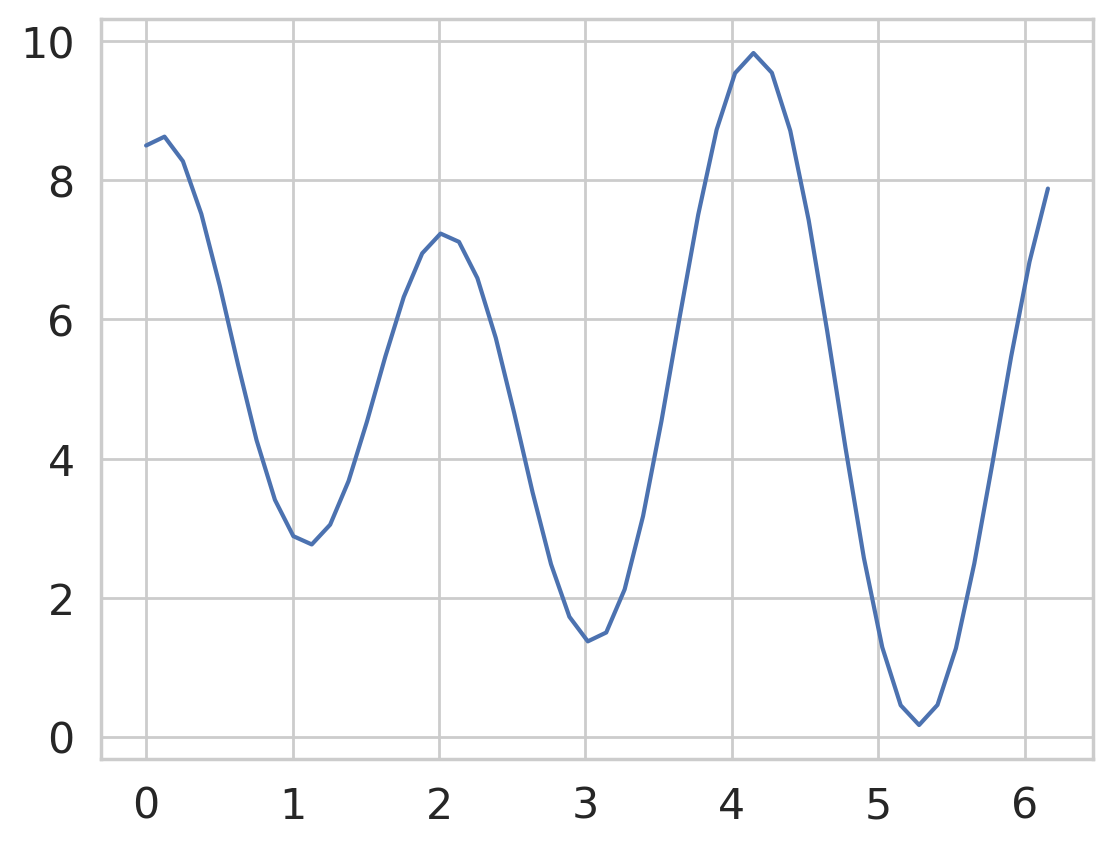

In [129]:
signal = Signal.from_sin_cos(
    sin_coeffs={2:1.5},
    cos_coeffs={3:3.5},
    base=5,
)

N = 50
t, x = signal.discretize(N)
plt.plot(t, x);

##### Тест написанных функции

IDFT - обратное проеброзование фурье

In [ ]:
xx = IDFT(DFT(x))
np.sum((xx - x)**2)

np.float64(5.2126694364924e-22)

DFT - проеброзование фурье

In [ ]:
np.sum((np.fft.fft(x) - DFT(x))**2)

np.complex128(1.7073590701566277e-19+2.1434896845280946e-20j)

##### Получение спектра

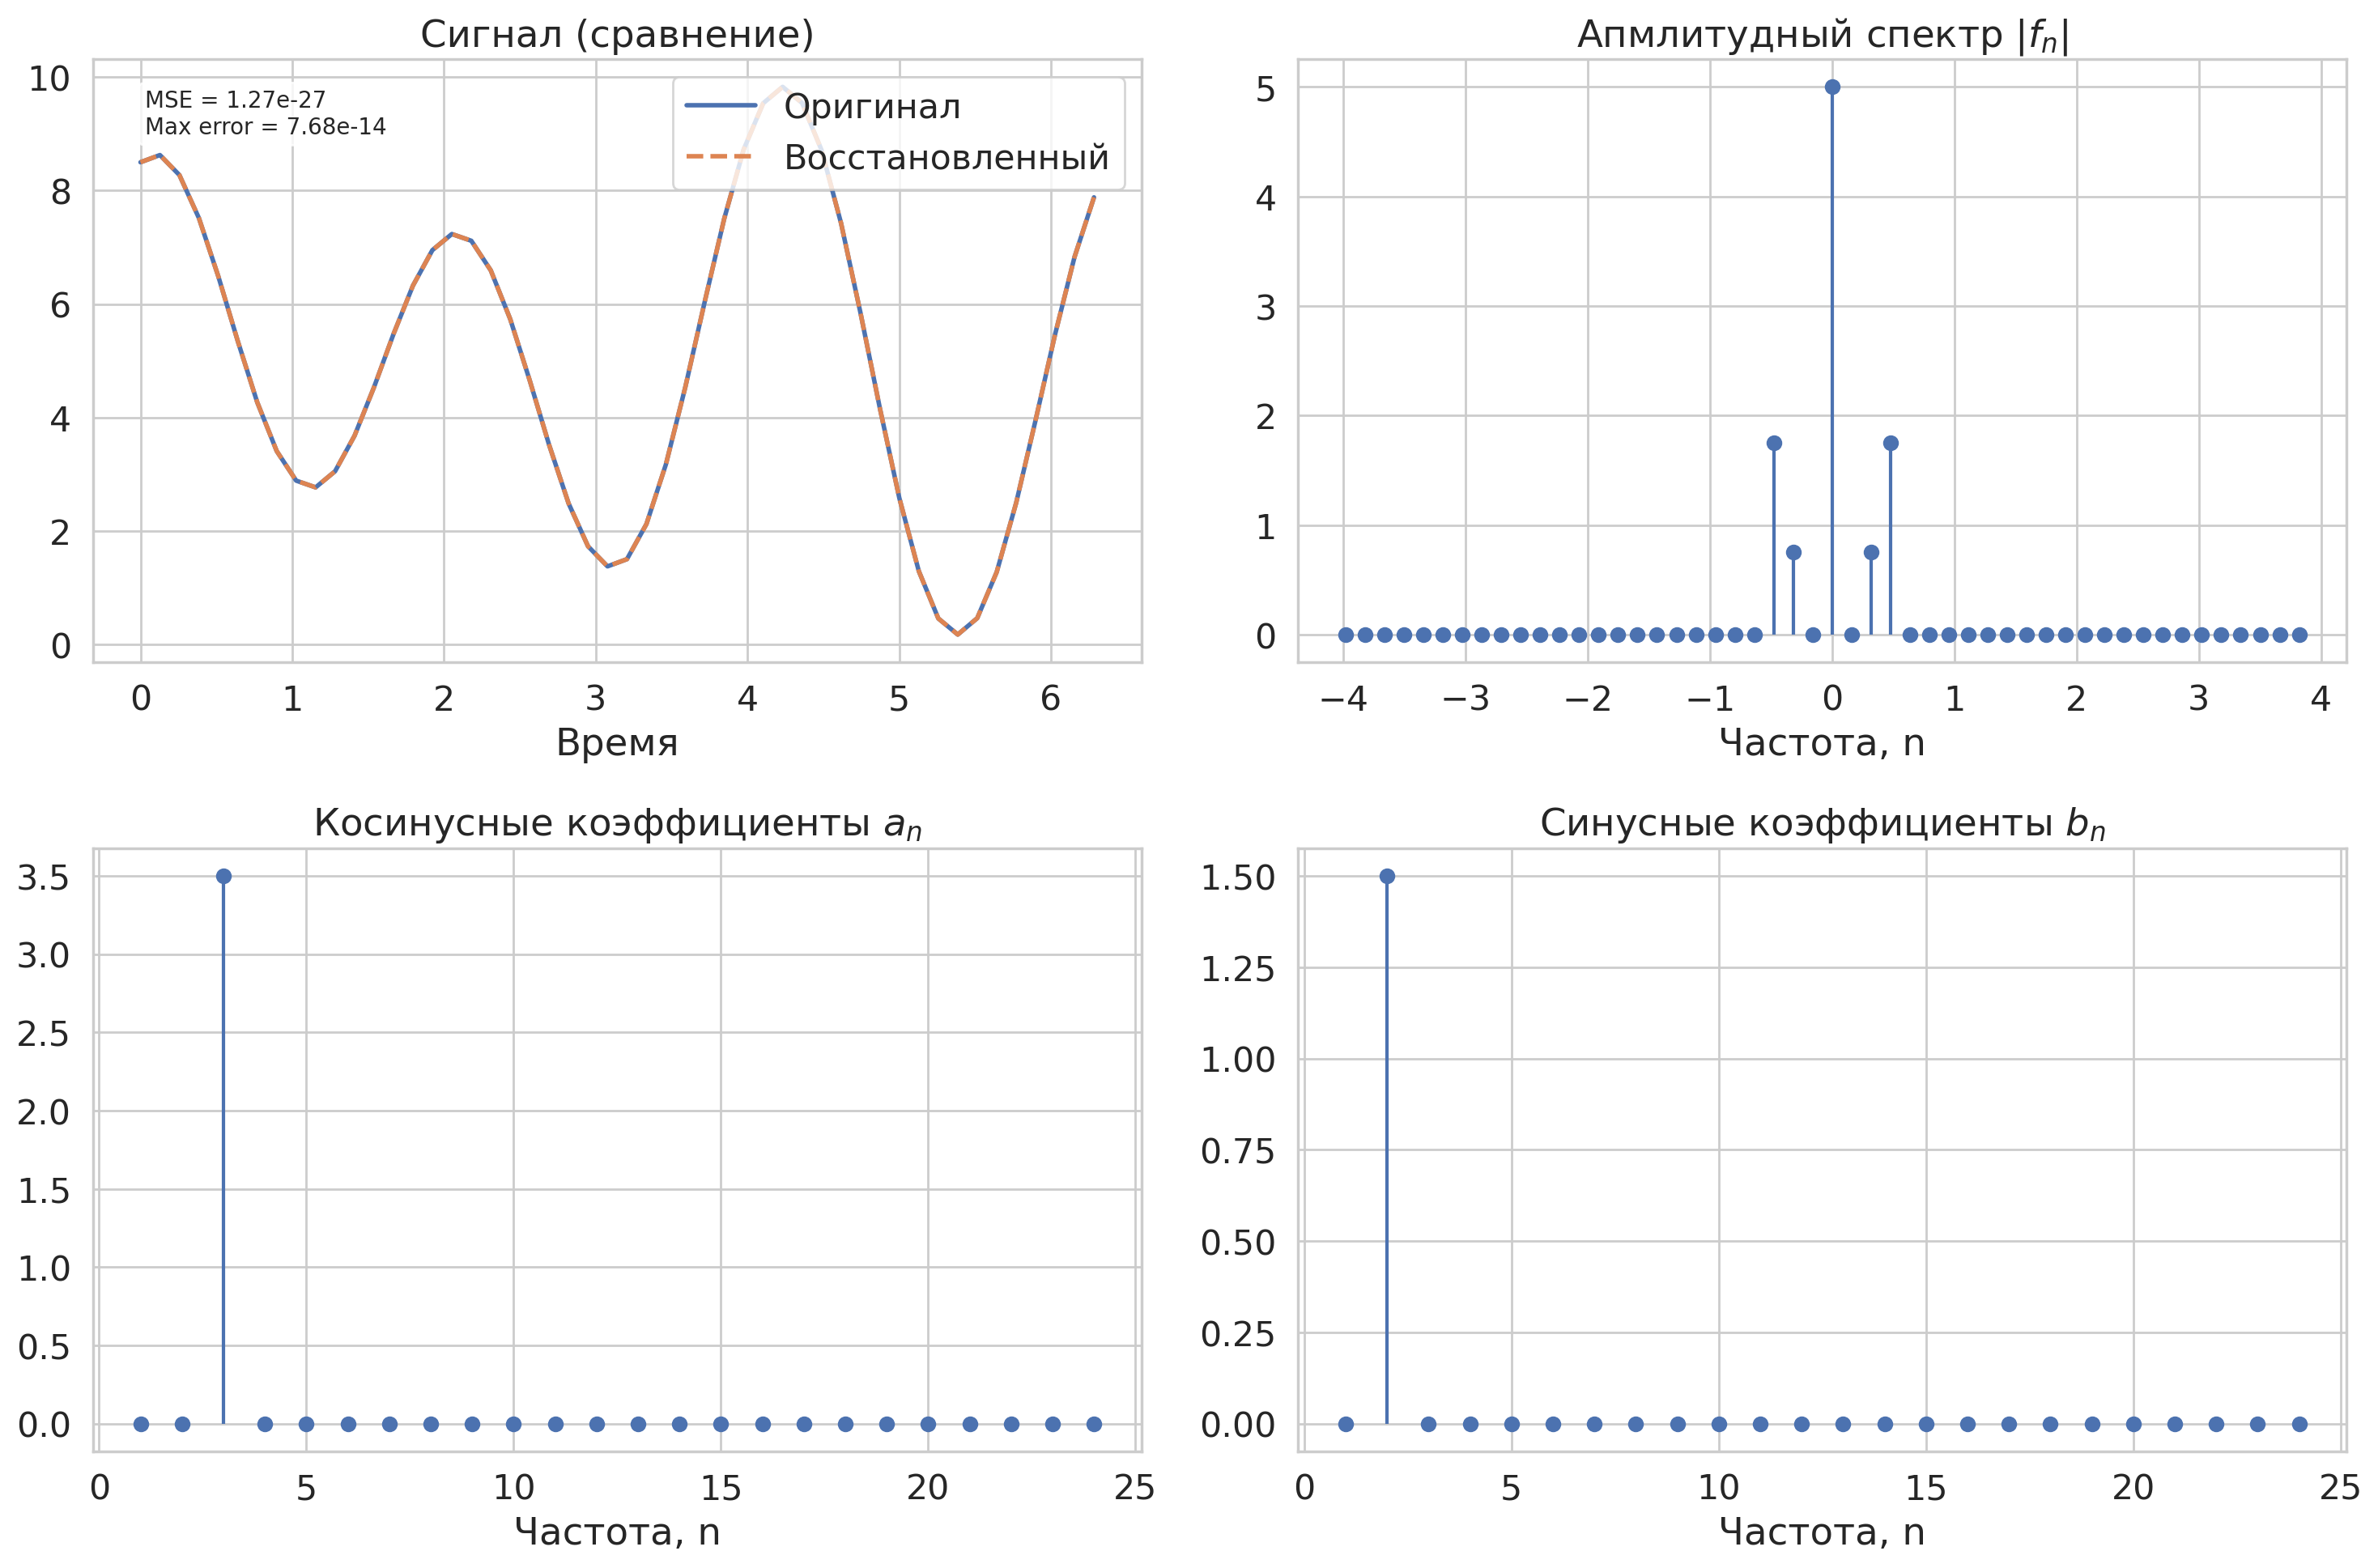

In [130]:
X = DFT(x)
plot_fourier_spectra(x, X, N, signal.T)

#### Еще пару простых примеров

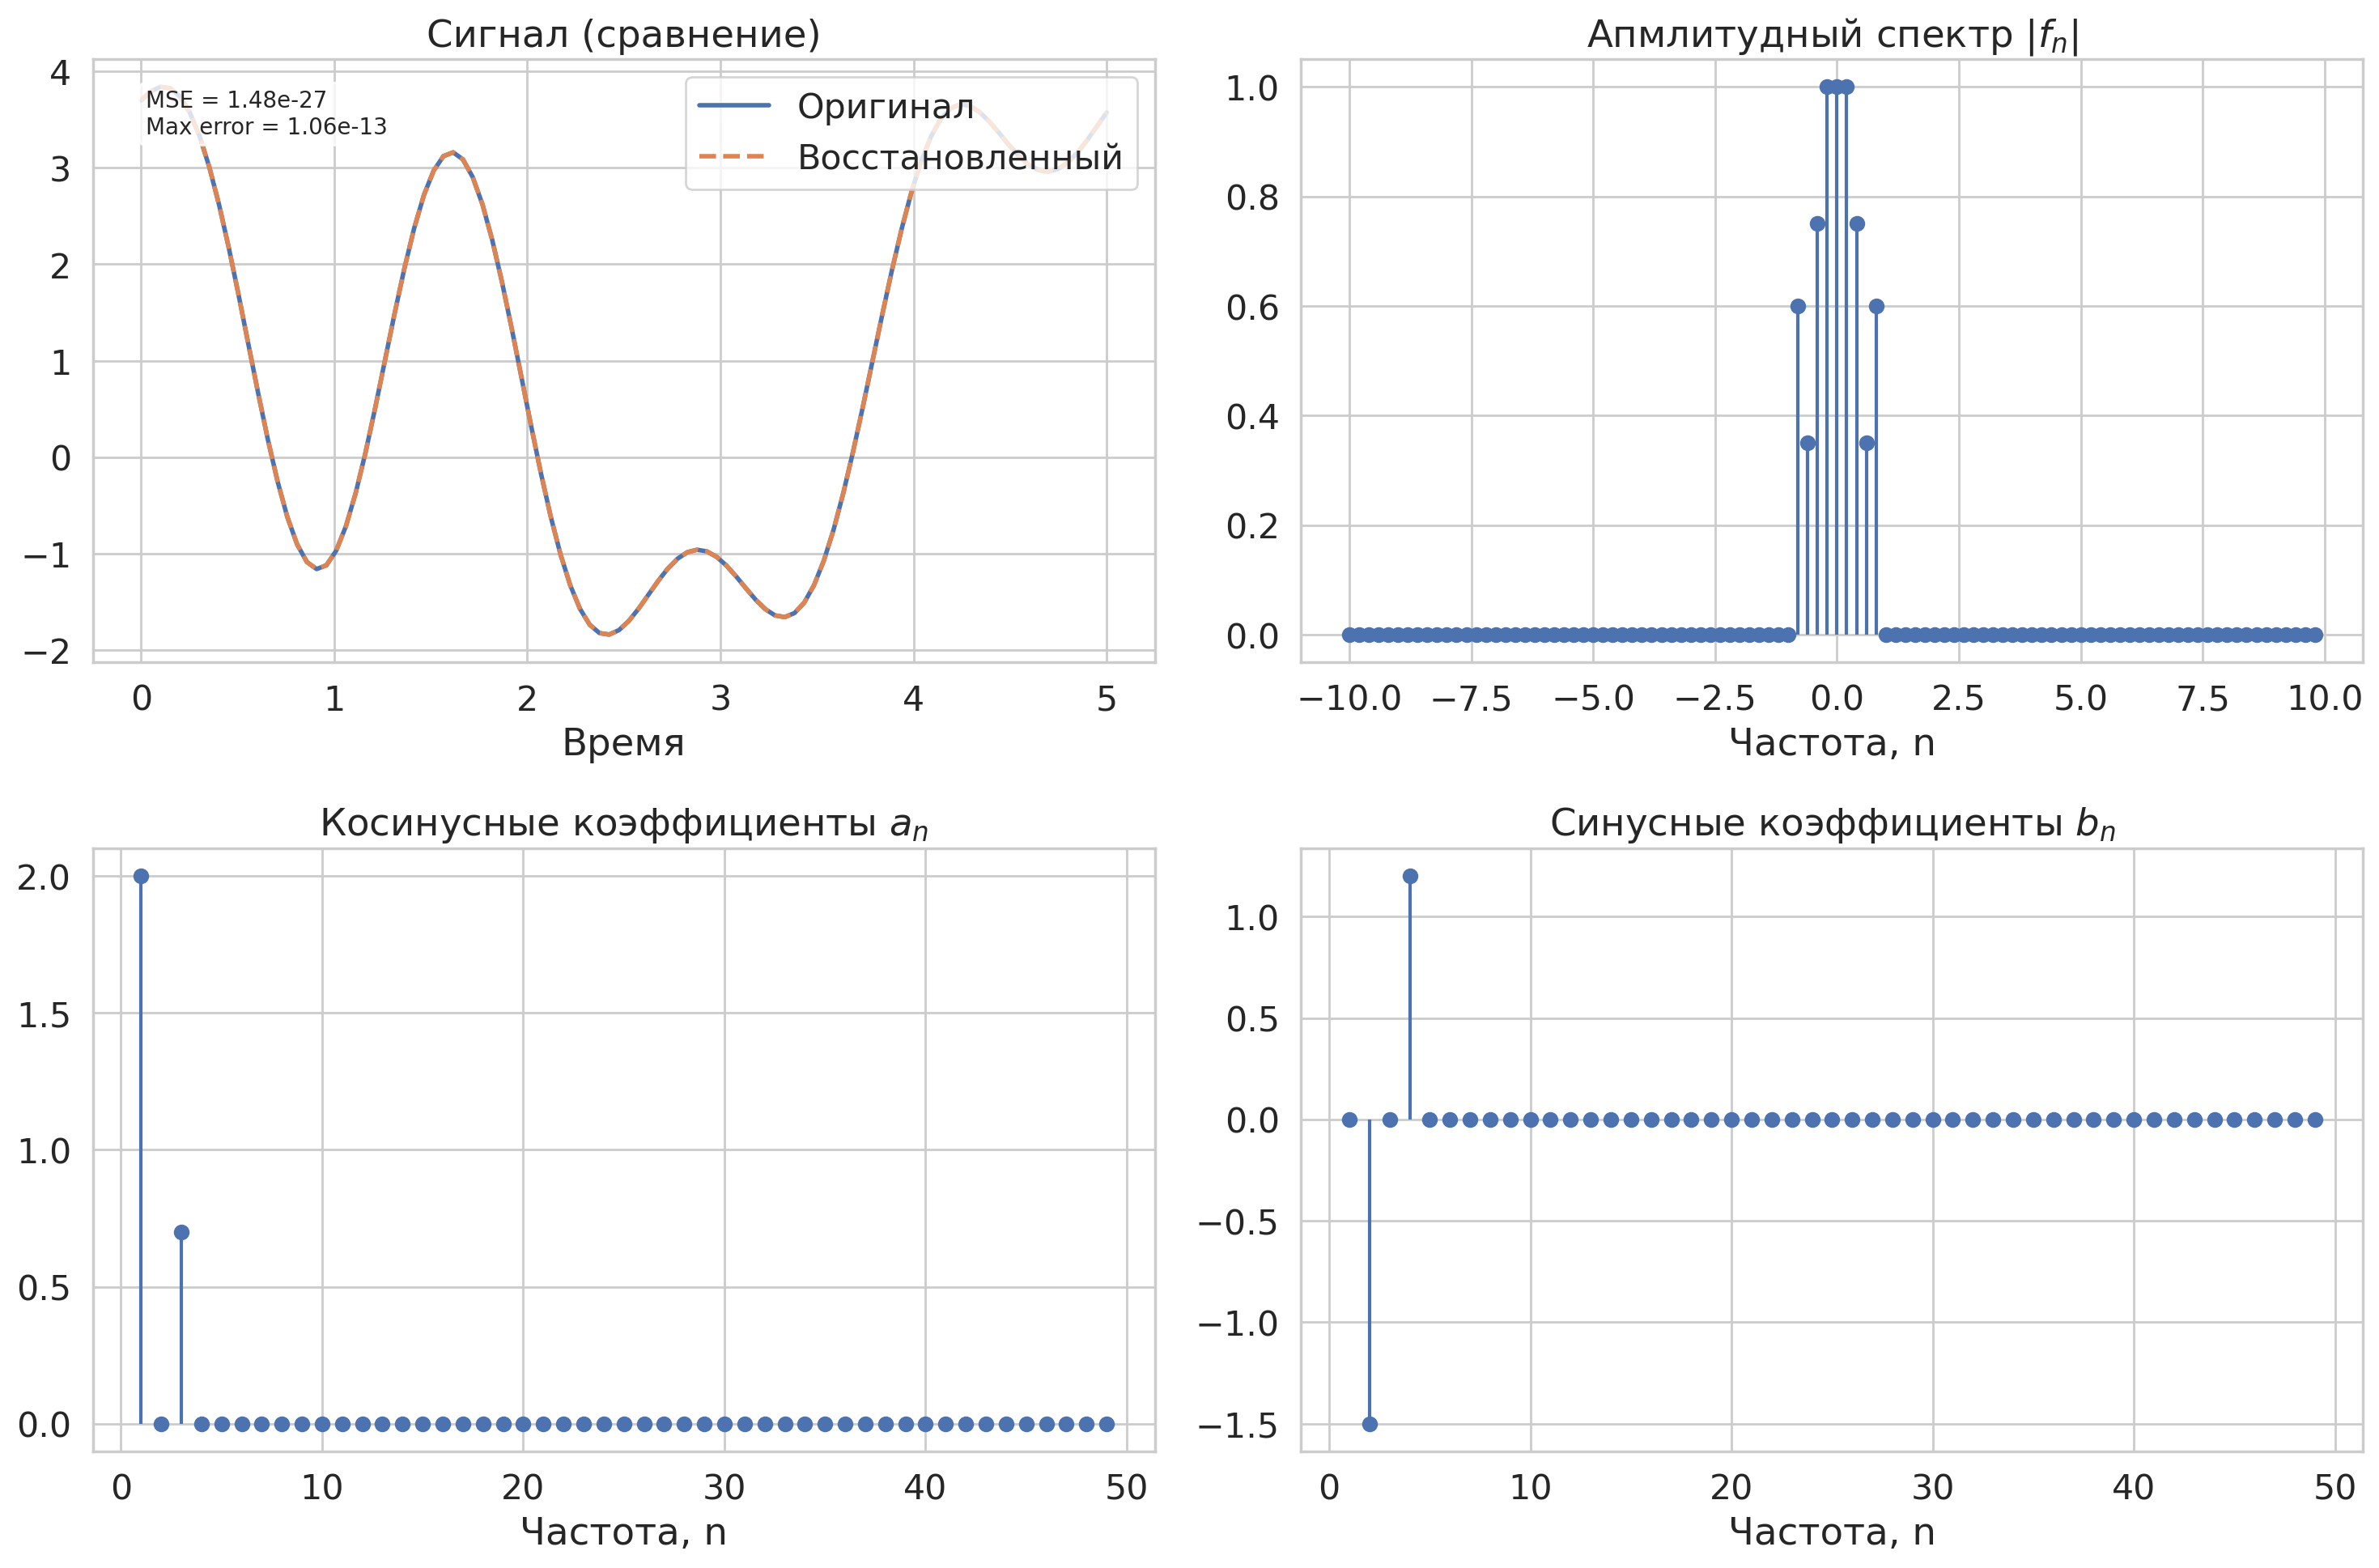

In [128]:
T = 5

cos_coeffs = {
    1: 2.0,
    3: 0.7,
}
sin_coeffs = {
    2: -1.5,
    4: 1.2,
}
a0 = 1.0

signal = Signal.from_sin_cos(
    sin_coeffs=sin_coeffs,
    cos_coeffs=cos_coeffs,
    base=a0,
    period=T
)

N = 100
t, x = signal.discretize(N)
X = DFT(x)
plot_fourier_spectra(x, X, N, signal.T)

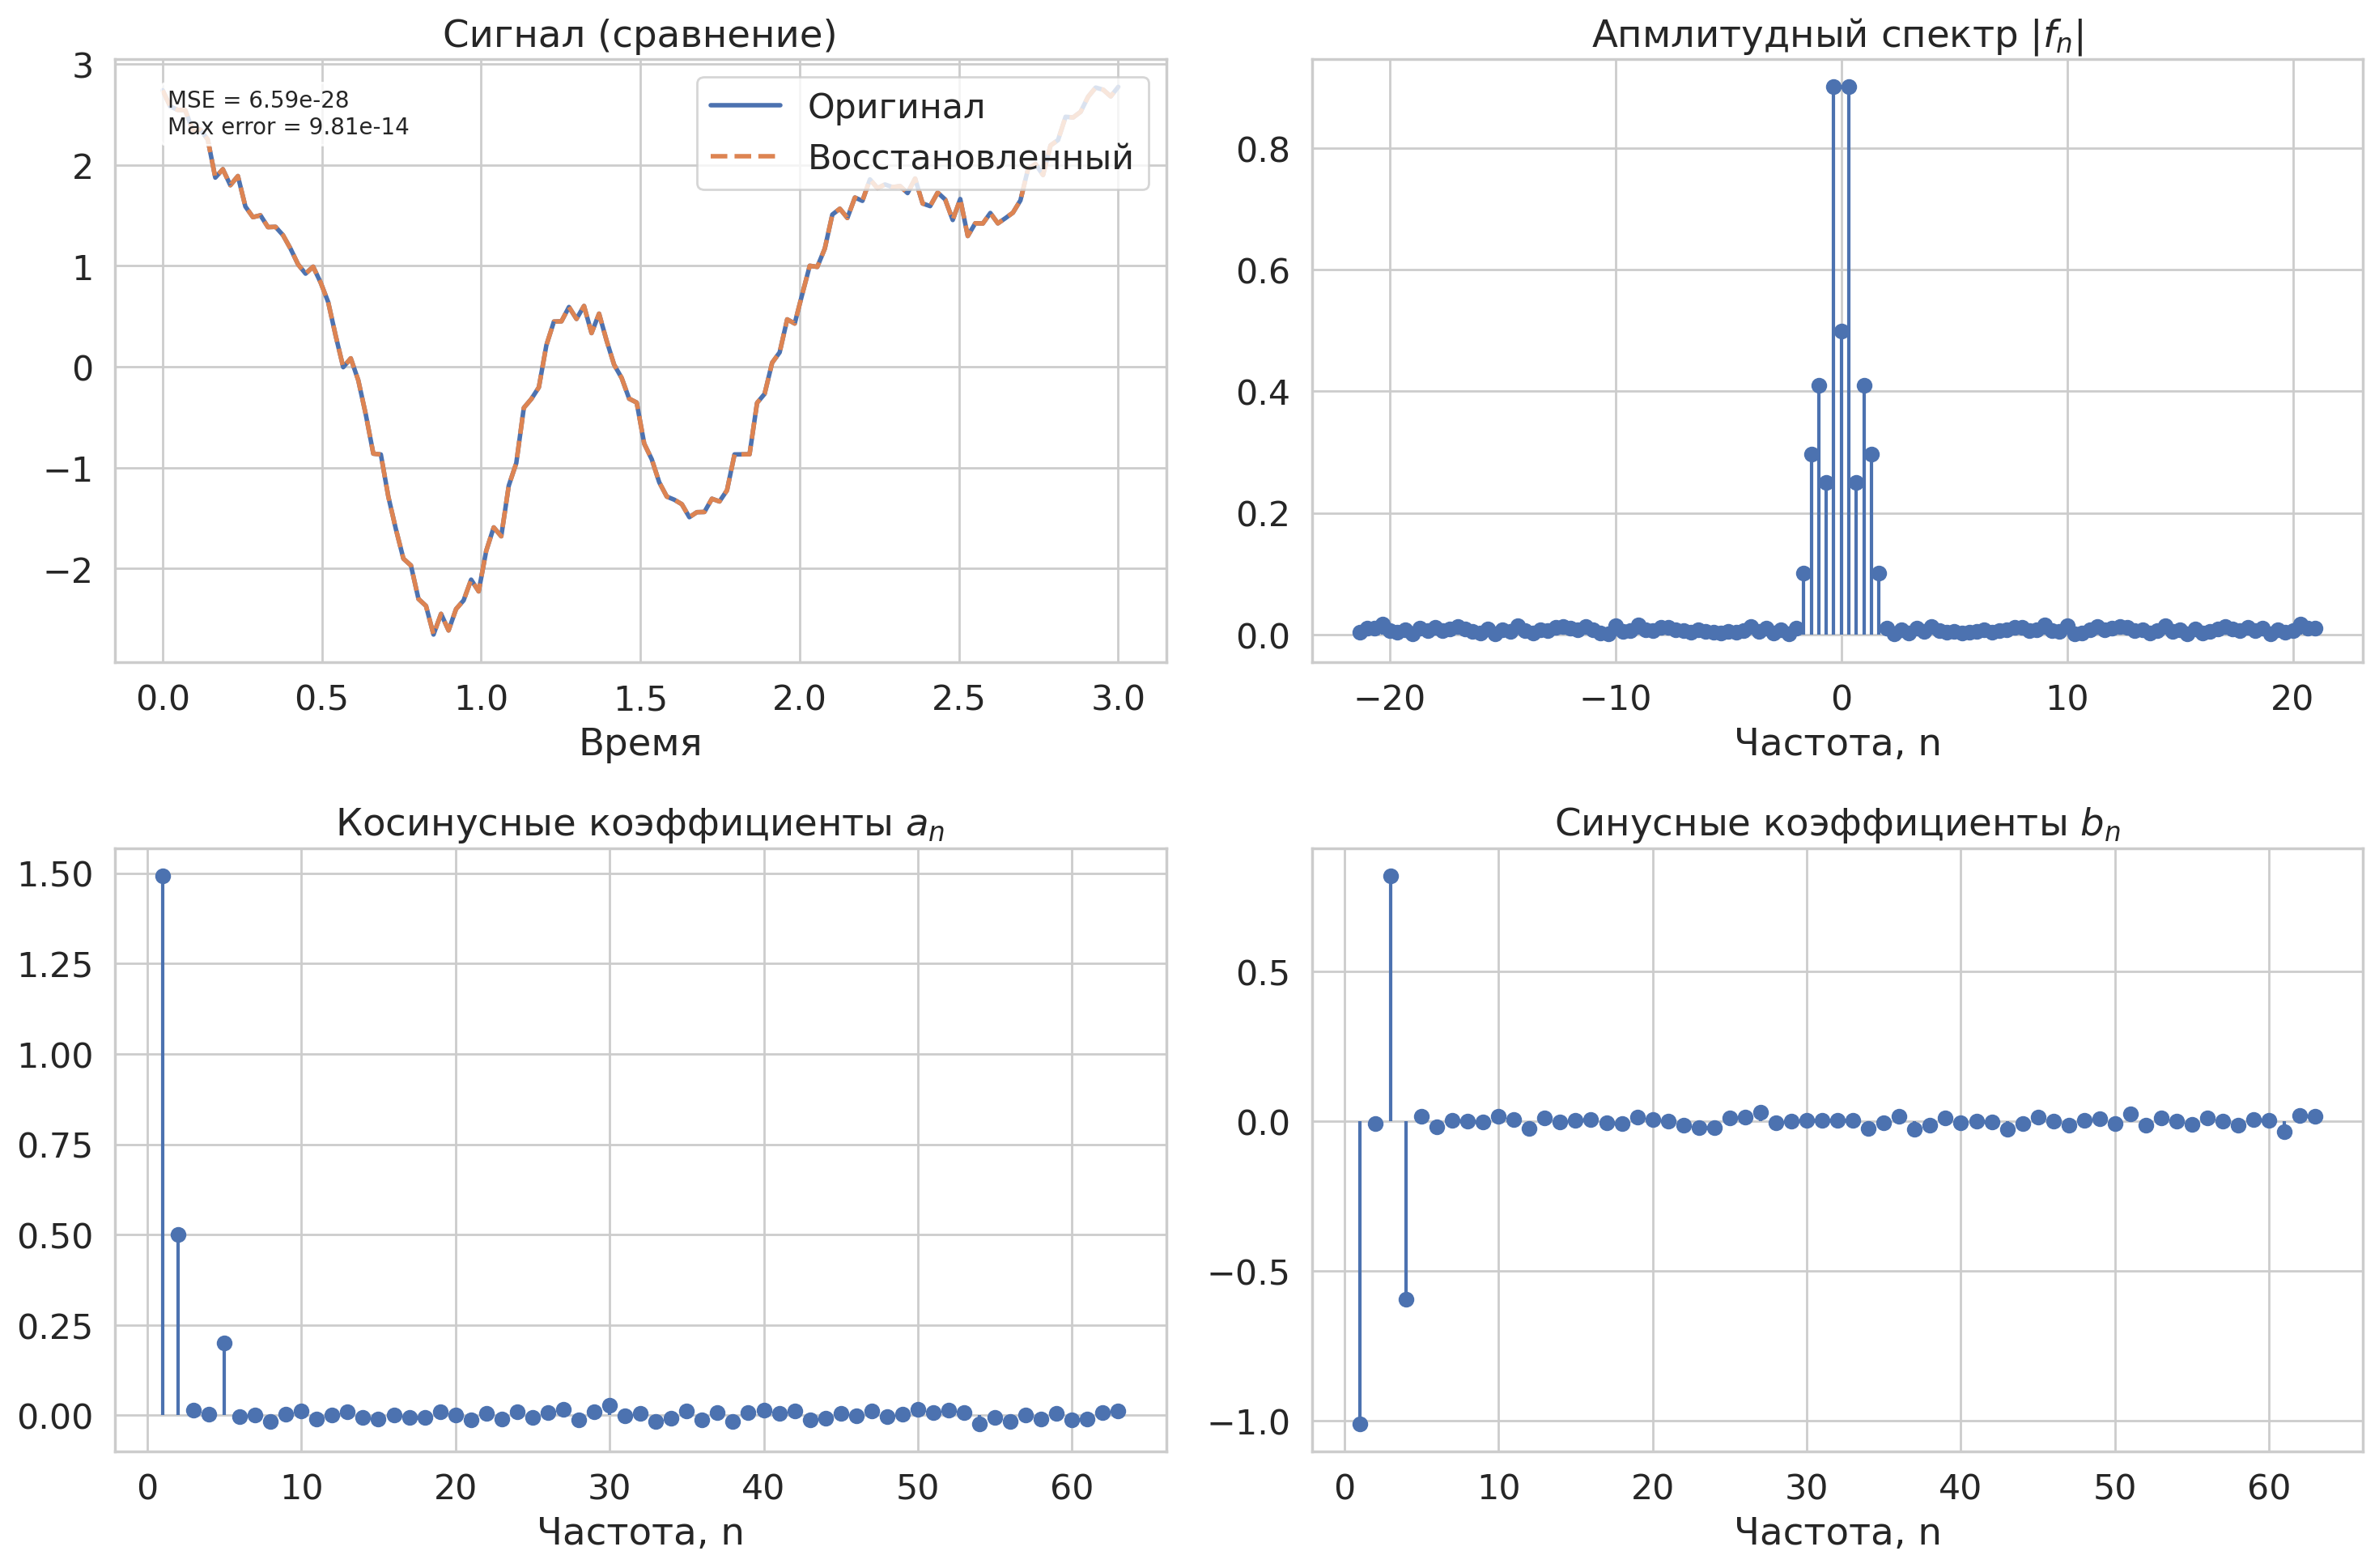

In [132]:
T1 = 3

cos_coeffs_1 = {
    1: 1.5,
    2: 0.5,
    5: 0.2,
}
sin_coeffs_1 = {
    1: -1.0,
    3: 0.8,
    4: -0.6,
}
a0_1 = 0.5

signal1 = Signal.from_sin_cos(
    sin_coeffs=sin_coeffs_1,
    cos_coeffs=cos_coeffs_1,
    base=a0_1,
    period=T1
)

N1 = 128
t1, x1 = signal1.discretize(N1)
x1 += 0.1 * np.random.randn(N1)  # Добавим шум
X1 = DFT(x1)
plot_fourier_spectra(x1, X1, N1, signal1.T)

### Работа с шумом

#### Полезные классы/функции

Класс для фильтрации шума.

In [223]:
class SignalFilter:
    def __init__(self, mode="ratio", threshold_ratio=0.05, top_k=None):
        self.mode = mode
        self.threshold_ratio = threshold_ratio
        self.top_k = top_k

        self.X_orig = None
        self.X_filtered = None
        self.freqs = None
        self.mask = None

    def fit_transform(self, t, x):
        N = len(x)
        dt = t[1] - t[0]

        X = np.fft.fft(x)
        X_norm = X / N
        self.X_orig = X_norm.copy()
        self.freqs = np.fft.fftfreq(N, d=dt)

        amplitudes = np.abs(X_norm)

        if self.mode == "ratio":
            max_amp = np.max(amplitudes)
            threshold = self.threshold_ratio * max_amp
            self.mask = amplitudes >= threshold

        elif self.mode == "topk":
            if self.top_k is None:
                raise ValueError("Для режима 'topk' необходимо указать top_k")
            idx = np.argsort(amplitudes)[-self.top_k:]
            self.mask = np.zeros_like(amplitudes, dtype=bool)
            self.mask[idx] = True

        else:
            raise ValueError(f"Неизвестный режим фильтрации: {self.mode}")

        X_filtered = X_norm * self.mask
        self.X_filtered = X_filtered
        x_filtered = np.fft.ifft(X_filtered * N)

        return x_filtered.real

    def inverse_mask(self):
        if self.X_orig is None:
            raise ValueError("Сначала вызови fit_transform")

        noise_mask = ~self.mask
        X_noise = self.X_orig * noise_mask
        return np.fft.ifft(X_noise * len(self.X_orig)).real

    def plot_spectra_comparison(self, t, x_true, x_filtered, figsize=(14, 5)):
        if self.X_orig is None or self.X_filtered is None or self.freqs is None:
            raise ValueError("Сначала вызови fit_transform")

        f_orig = np.fft.fftshift(self.X_orig)
        f_filt = np.fft.fftshift(self.X_filtered)
        freqs = np.fft.fftshift(self.freqs)
        amplitudes = np.abs(f_orig)
        mask = np.fft.fftshift(self.mask)

        mse = np.mean((x_true - x_filtered) ** 2)
        max_err = np.max(np.abs(x_true - x_filtered))

        fig, axs = plt.subplots(1, 2, figsize=figsize)

        axs[0].plot(t, x_true, label="Истинный сигнал", alpha=0.5)
        axs[0].plot(t, x_filtered, label="После фильтра", linewidth=2)
        axs[0].legend(loc=1)
        axs[0].grid(True)
        axs[0].set_title("Сравнение: истинный и отфильтрованный сигнал")
        axs[0].text(
            0.05,
            0.95,
            f"MSE = {mse:.2e}\nMax error = {max_err:.2e}",
            transform=axs[0].transAxes,
            verticalalignment="top",
            fontsize=10,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

        axs[1].stem(freqs, amplitudes, linefmt="gray", markerfmt="D", basefmt=" ")
        axs[1].stem(freqs[mask], amplitudes[mask], linefmt="r", markerfmt="ro", basefmt=" ")
        axs[1].set_title("Амплитудный спектр (выделены оставшиеся частоты)")
        axs[1].set_xlabel("Частота")
        axs[1].set_ylabel("Амплитуда")
        axs[1].grid(True)

        plt.tight_layout()
        return fig, axs

#### Простые примеры с шумом

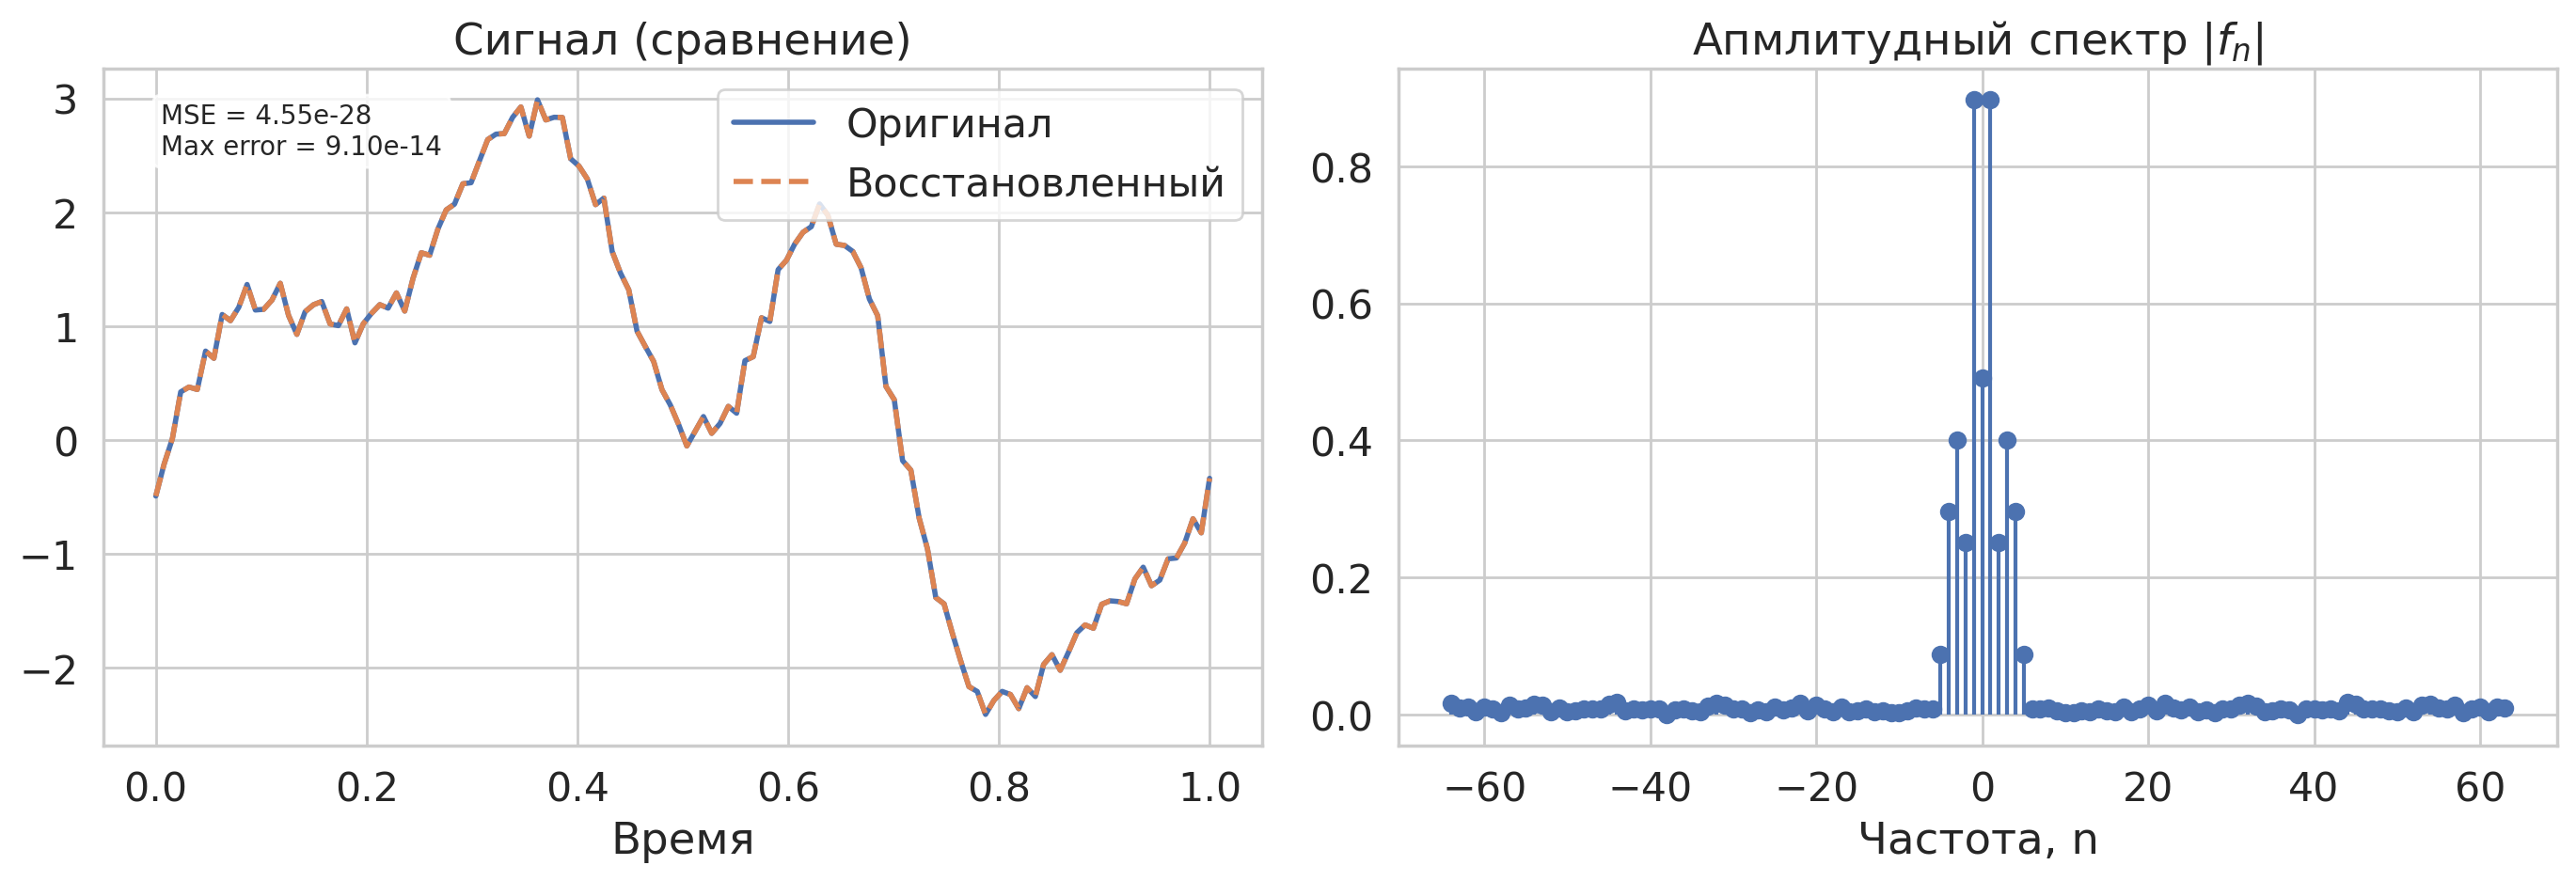

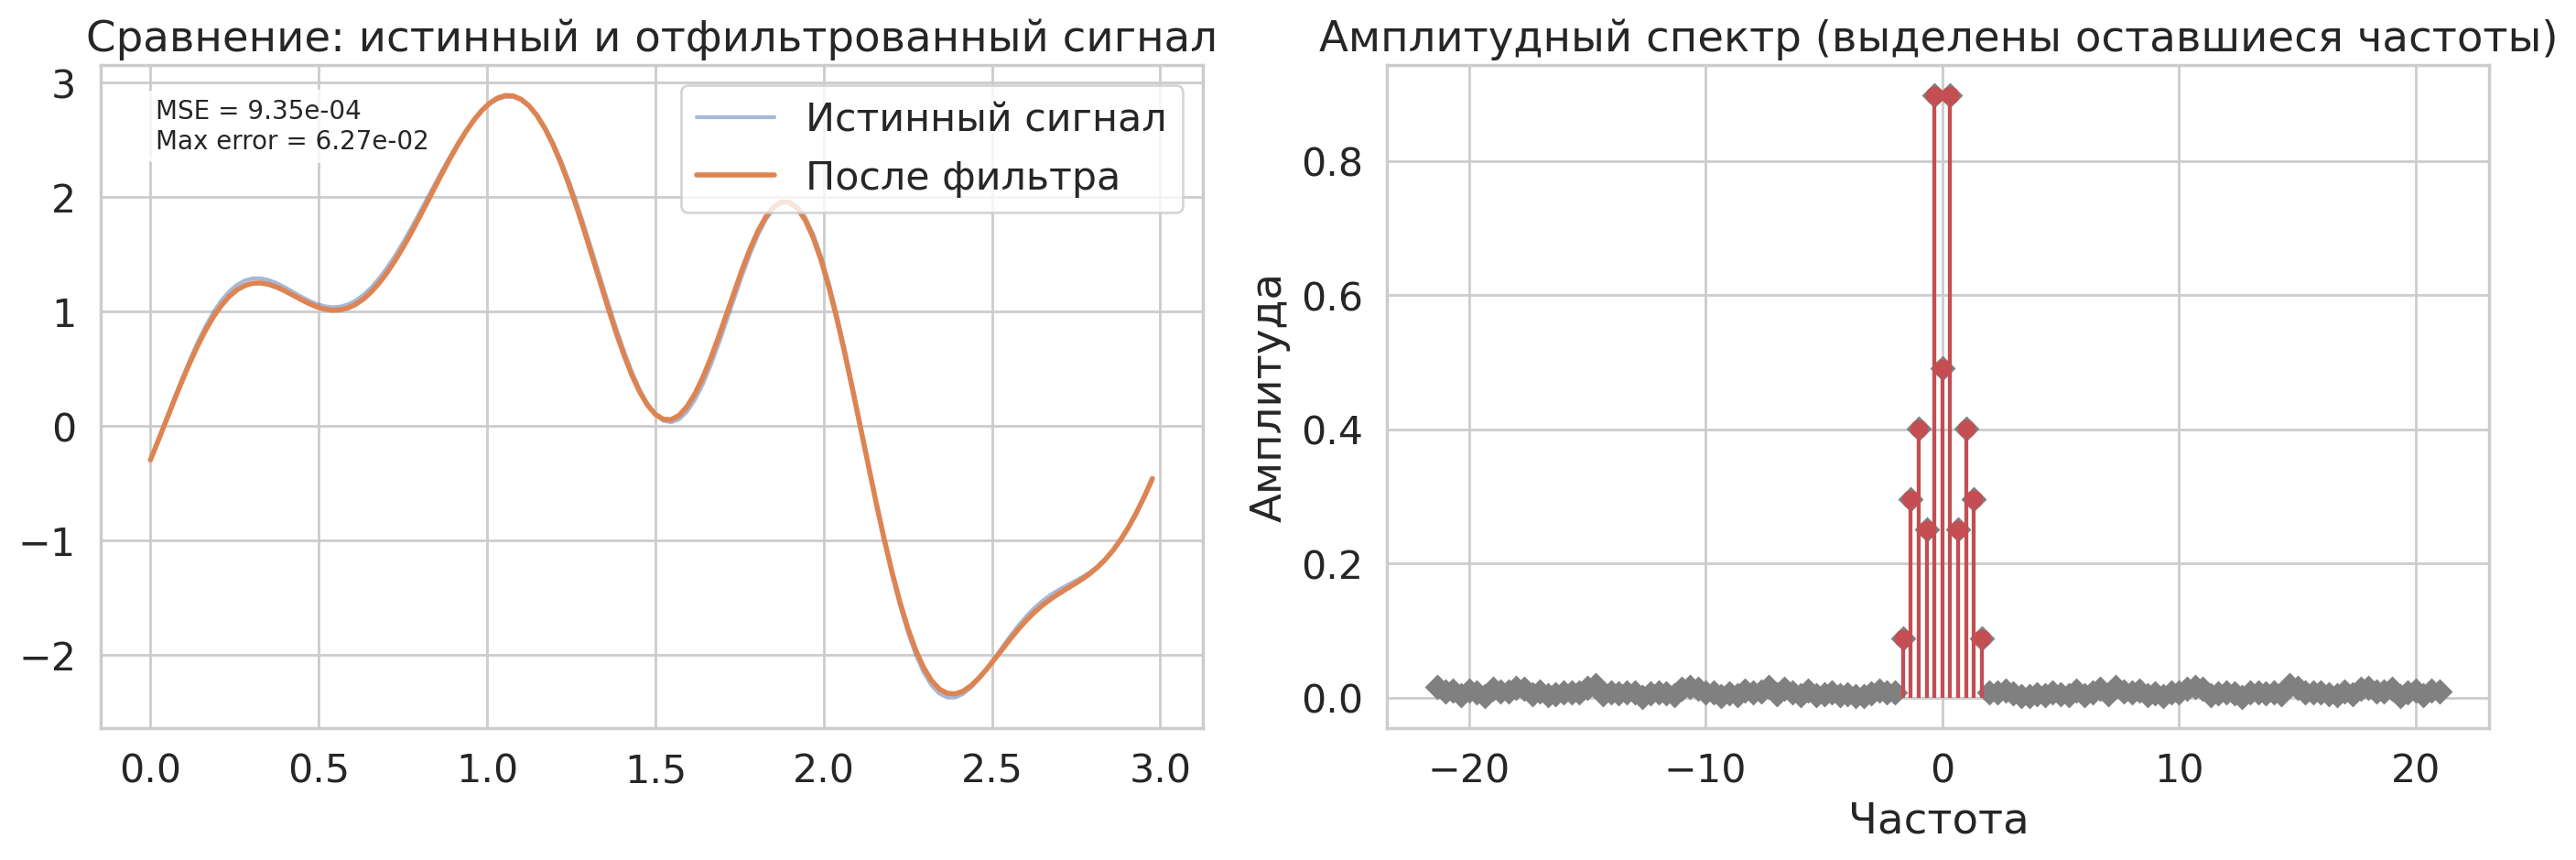

In [224]:
signal = Signal.from_sin_cos(
    sin_coeffs={
        1: 1.5,
        2: 0.5,
        5: 0.2,
    },
    cos_coeffs={
        1: -1.0,
        3: 0.8,
        4: -0.6,
    },
    base=0.5,
    period=3,
)

N = 128
t, x_clean = signal.discretize(N)
noise = 0.1 * np.random.randn(N)
x_noisy = x_clean + noise

X = DFT(x_noisy)
plot_fourier_spectra(x_noisy, X, N, T, plot_sin_cos=False, figsize=(14, 5))

filter = SignalFilter()
x_filtered = filter.fit_transform(t, x_noisy)

filter.plot_spectra_comparison(t, x_filtered=x_filtered, x_true=x_clean, figsize=(14, 5))
plt.show()

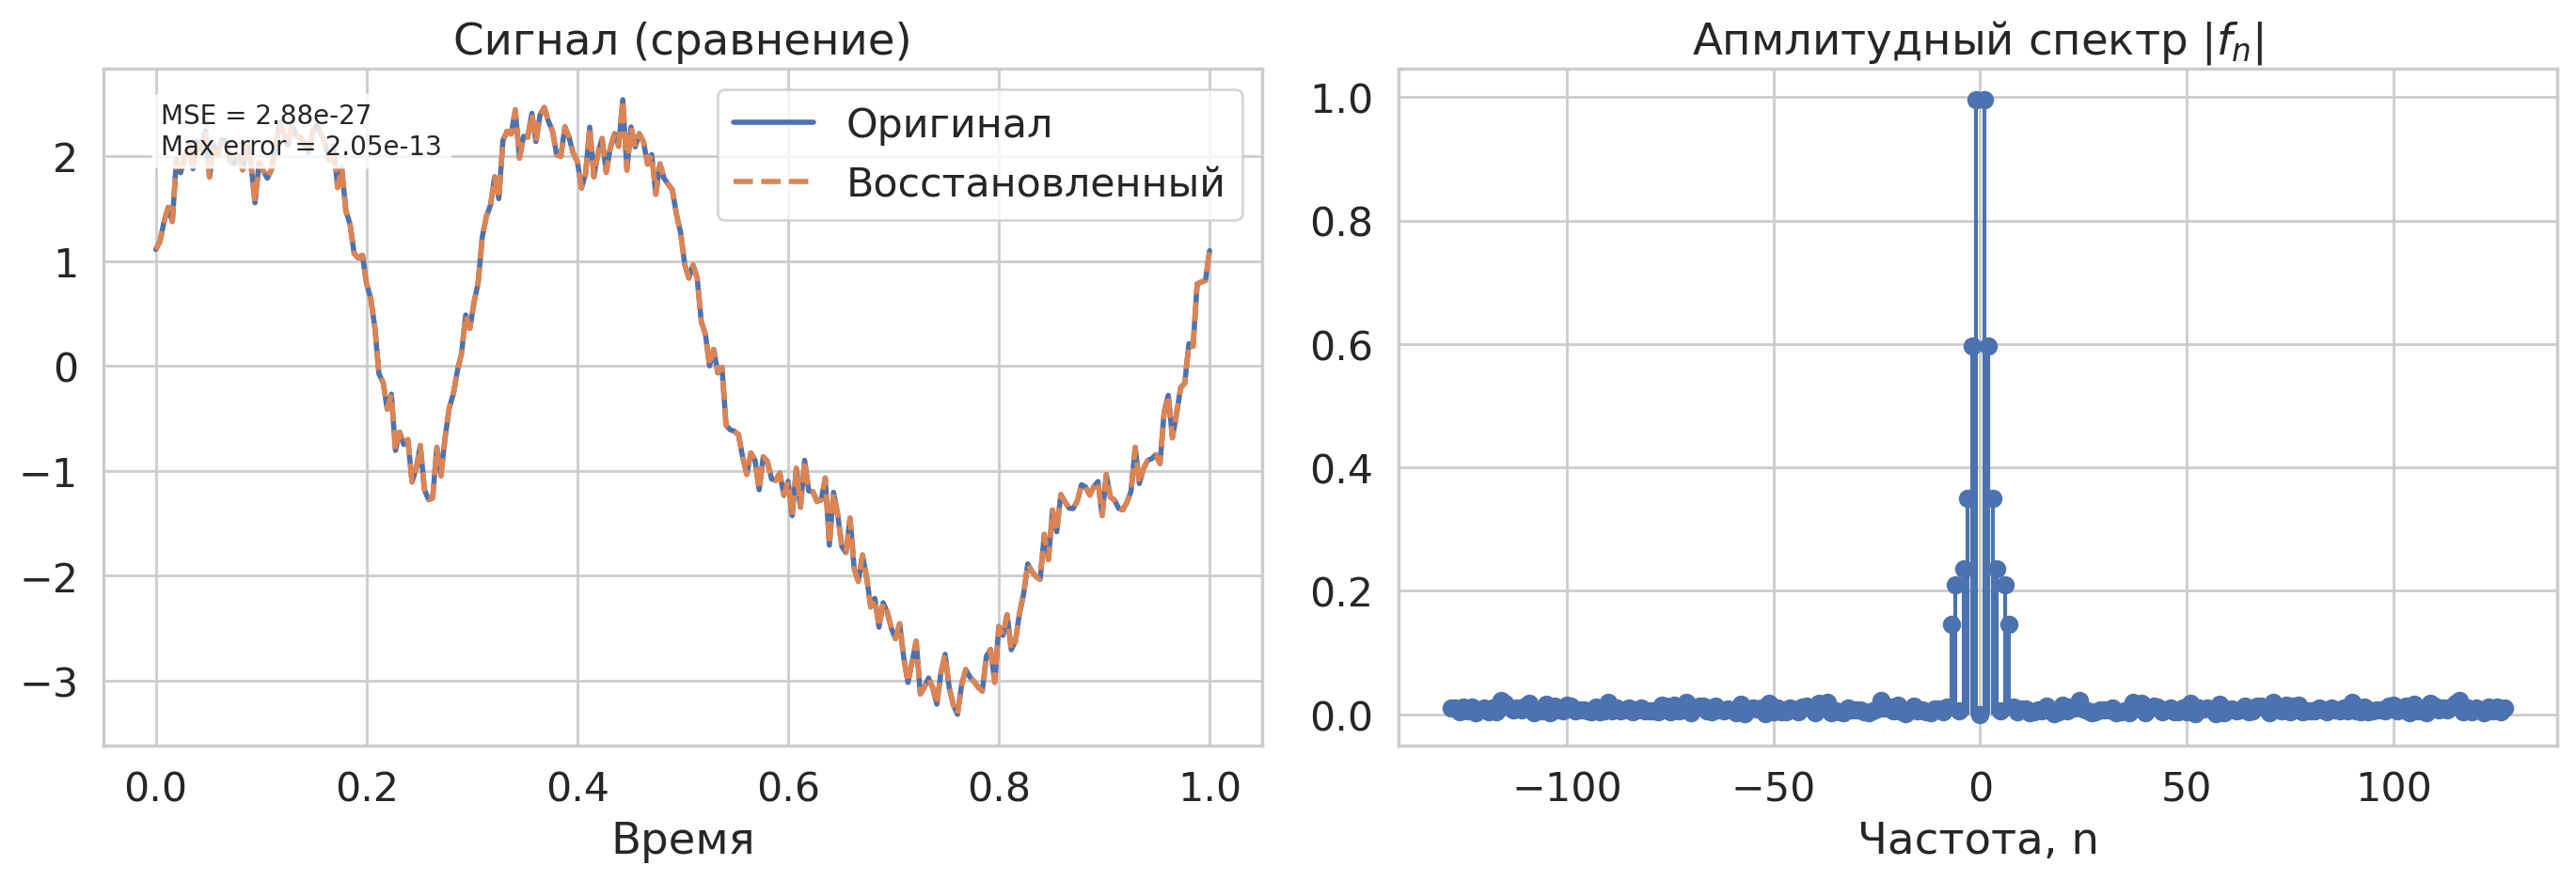

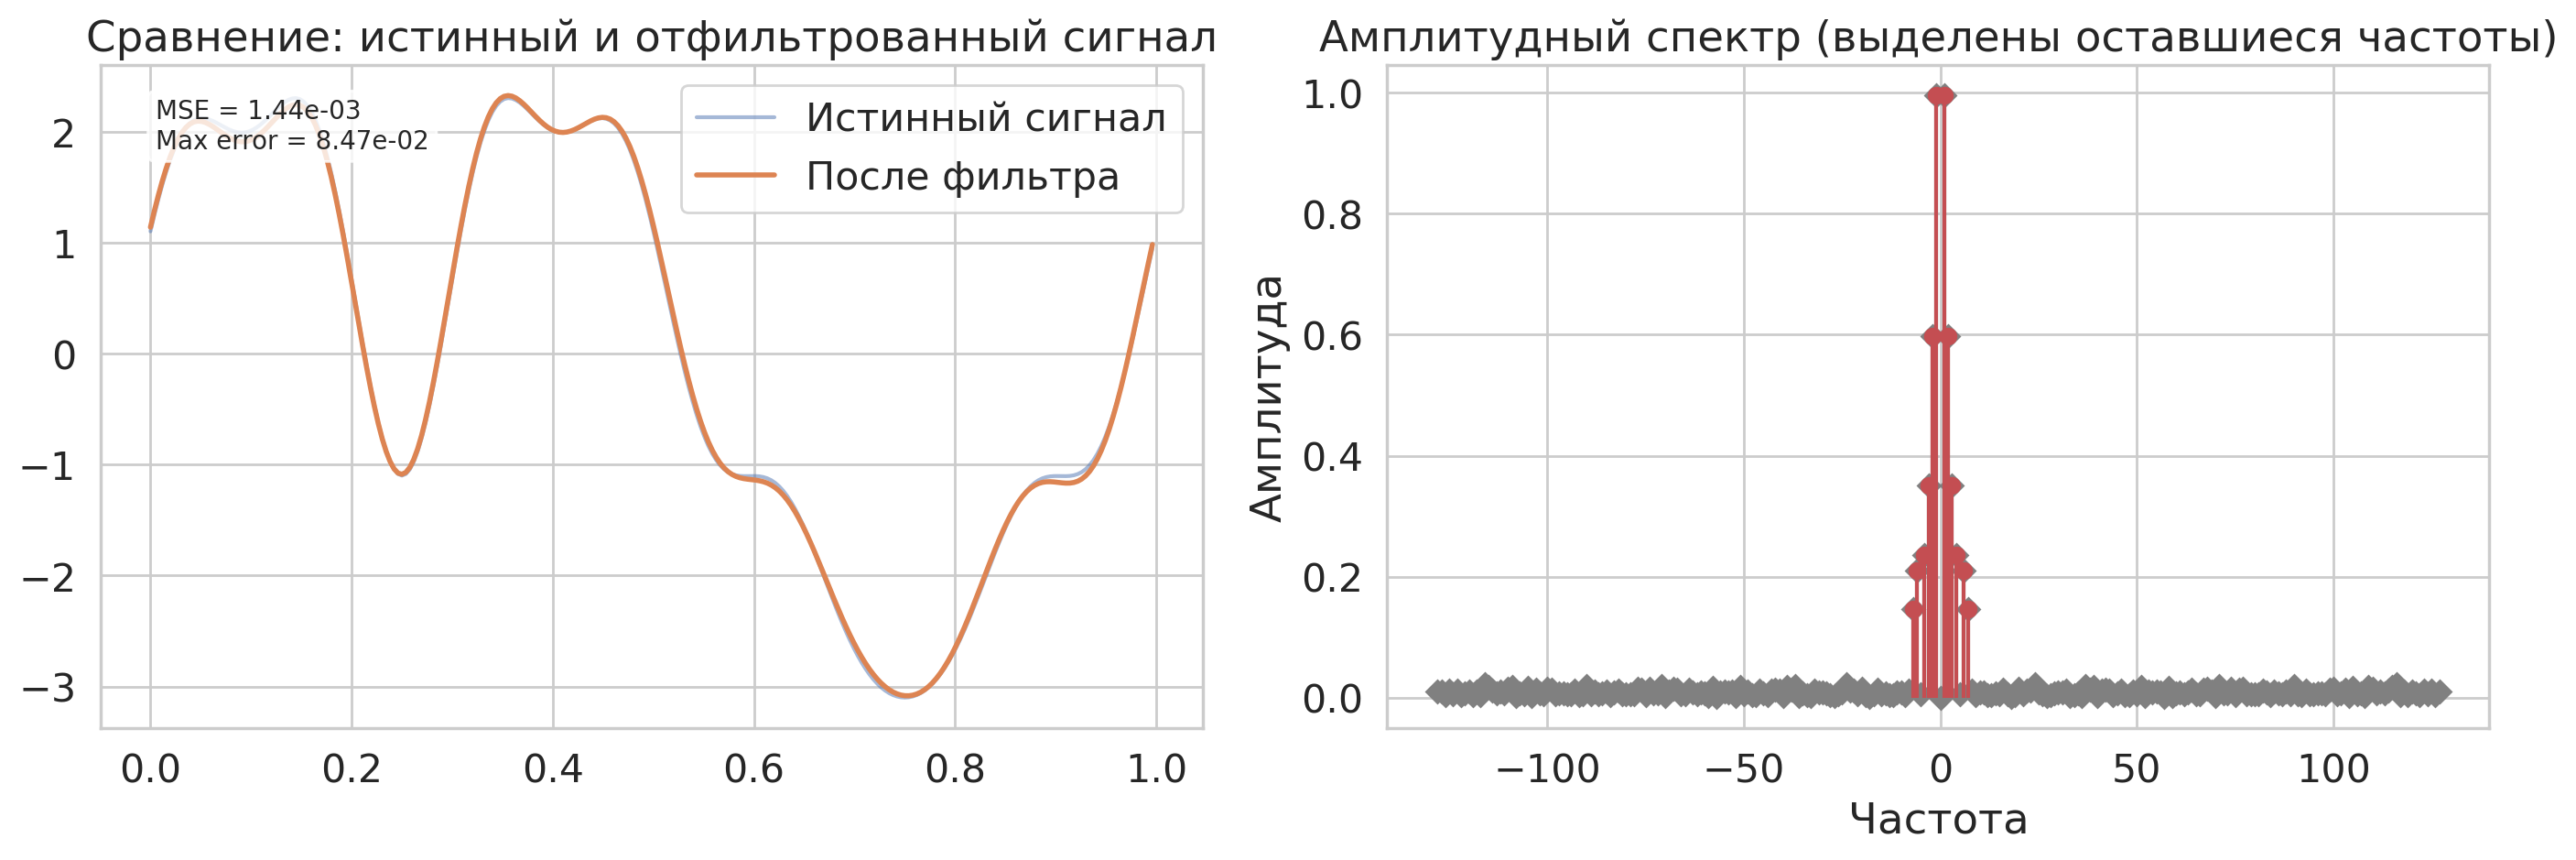

In [225]:
signal = Signal.from_sin_cos(
    sin_coeffs={
        1: 2.0,
        3: 0.7,
        7: 0.3,
    },
    cos_coeffs={
        2: 1.2,
        4: -0.5,
        6: 0.4,
    },
    base=0.0,
    period=1.0,
)

N = 256
t, x_clean = signal.discretize(N)

noise = 0.15 * np.random.randn(N)
x_noisy = x_clean + noise

X = DFT(x_noisy)

plot_fourier_spectra(x_noisy, X, N, period=1.0, plot_sin_cos=False, figsize=(14, 5))

filter = SignalFilter(threshold_ratio=0.1)
x_filtered = filter.fit_transform(t, x_noisy)

filter.plot_spectra_comparison(t, x_filtered=x_filtered, x_true=x_clean, figsize=(14, 5))
plt.show()

#### ECG-подобный сигнал

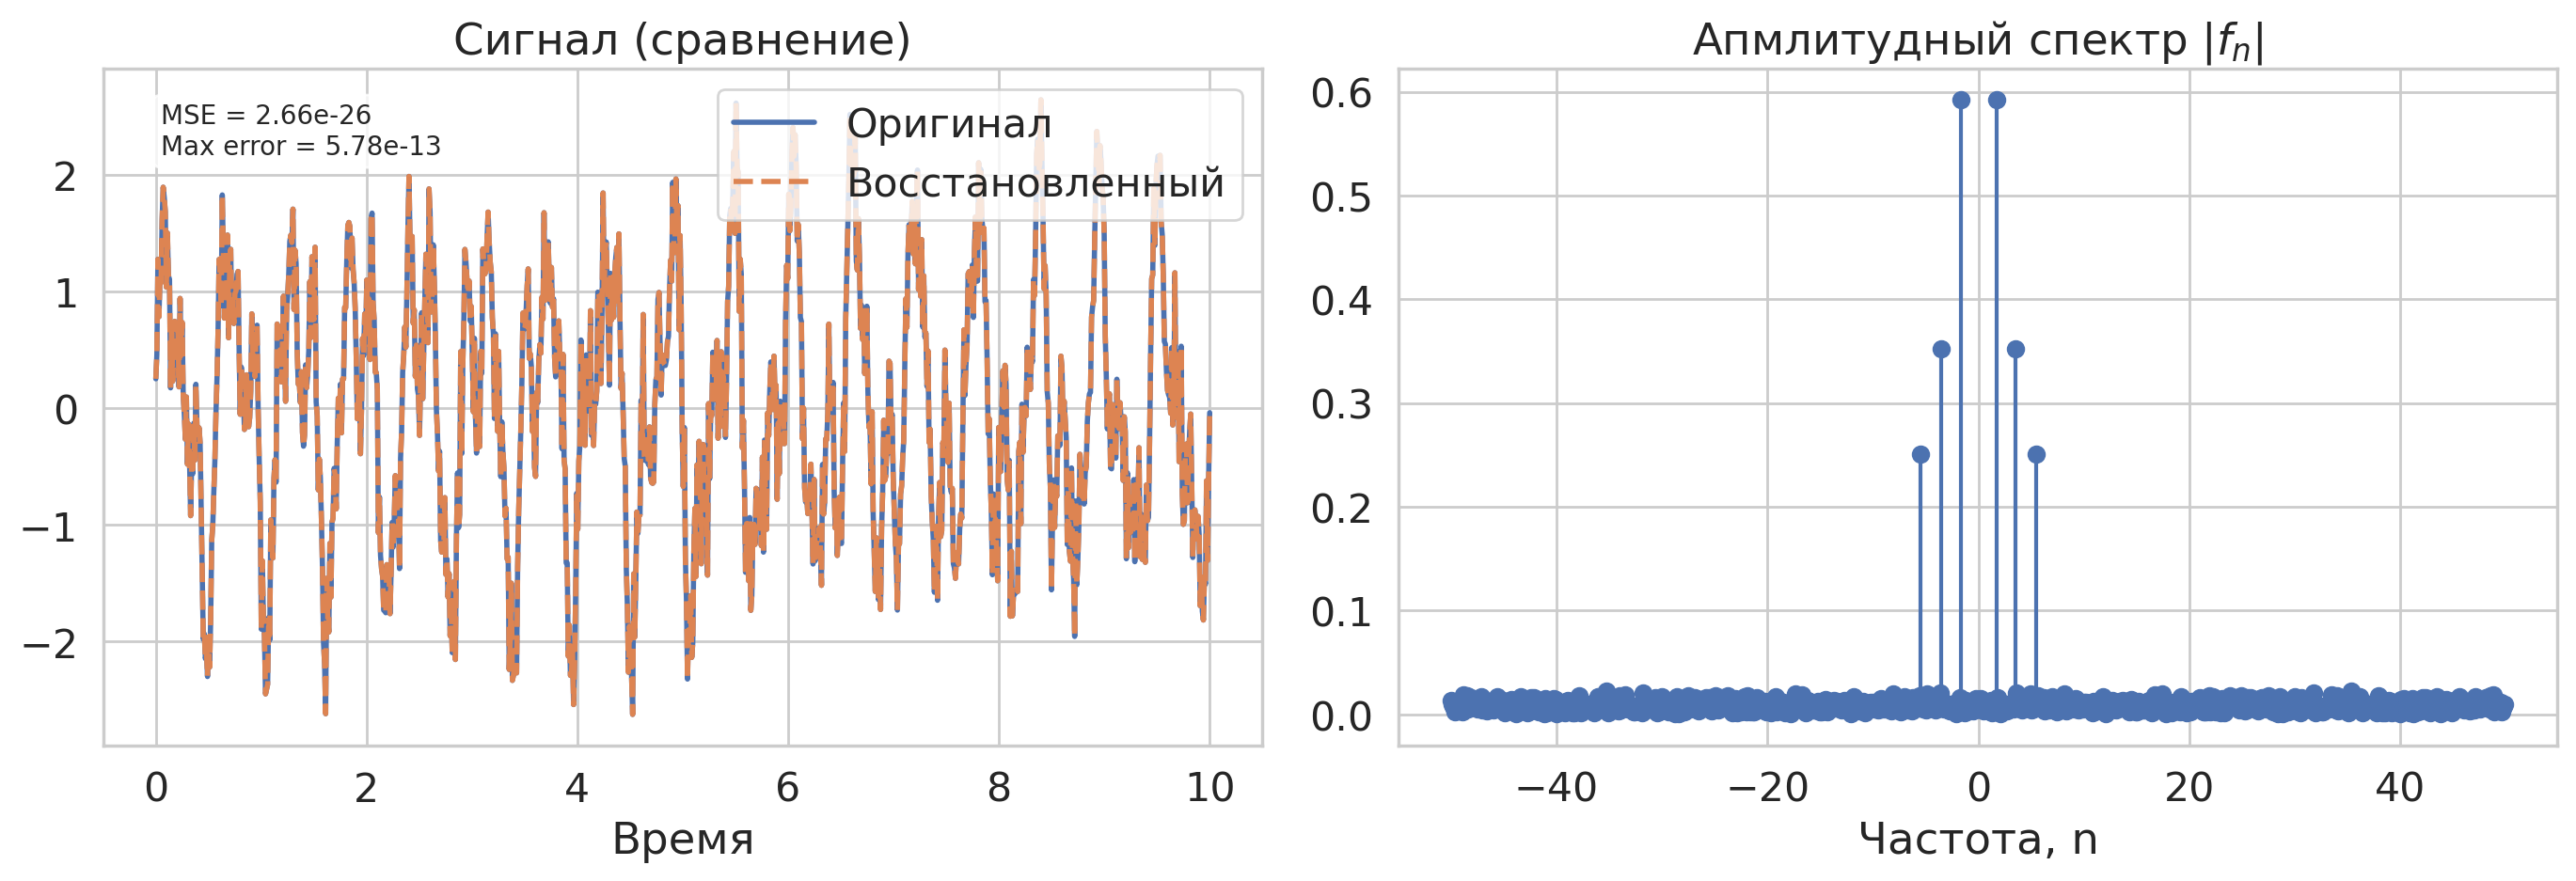

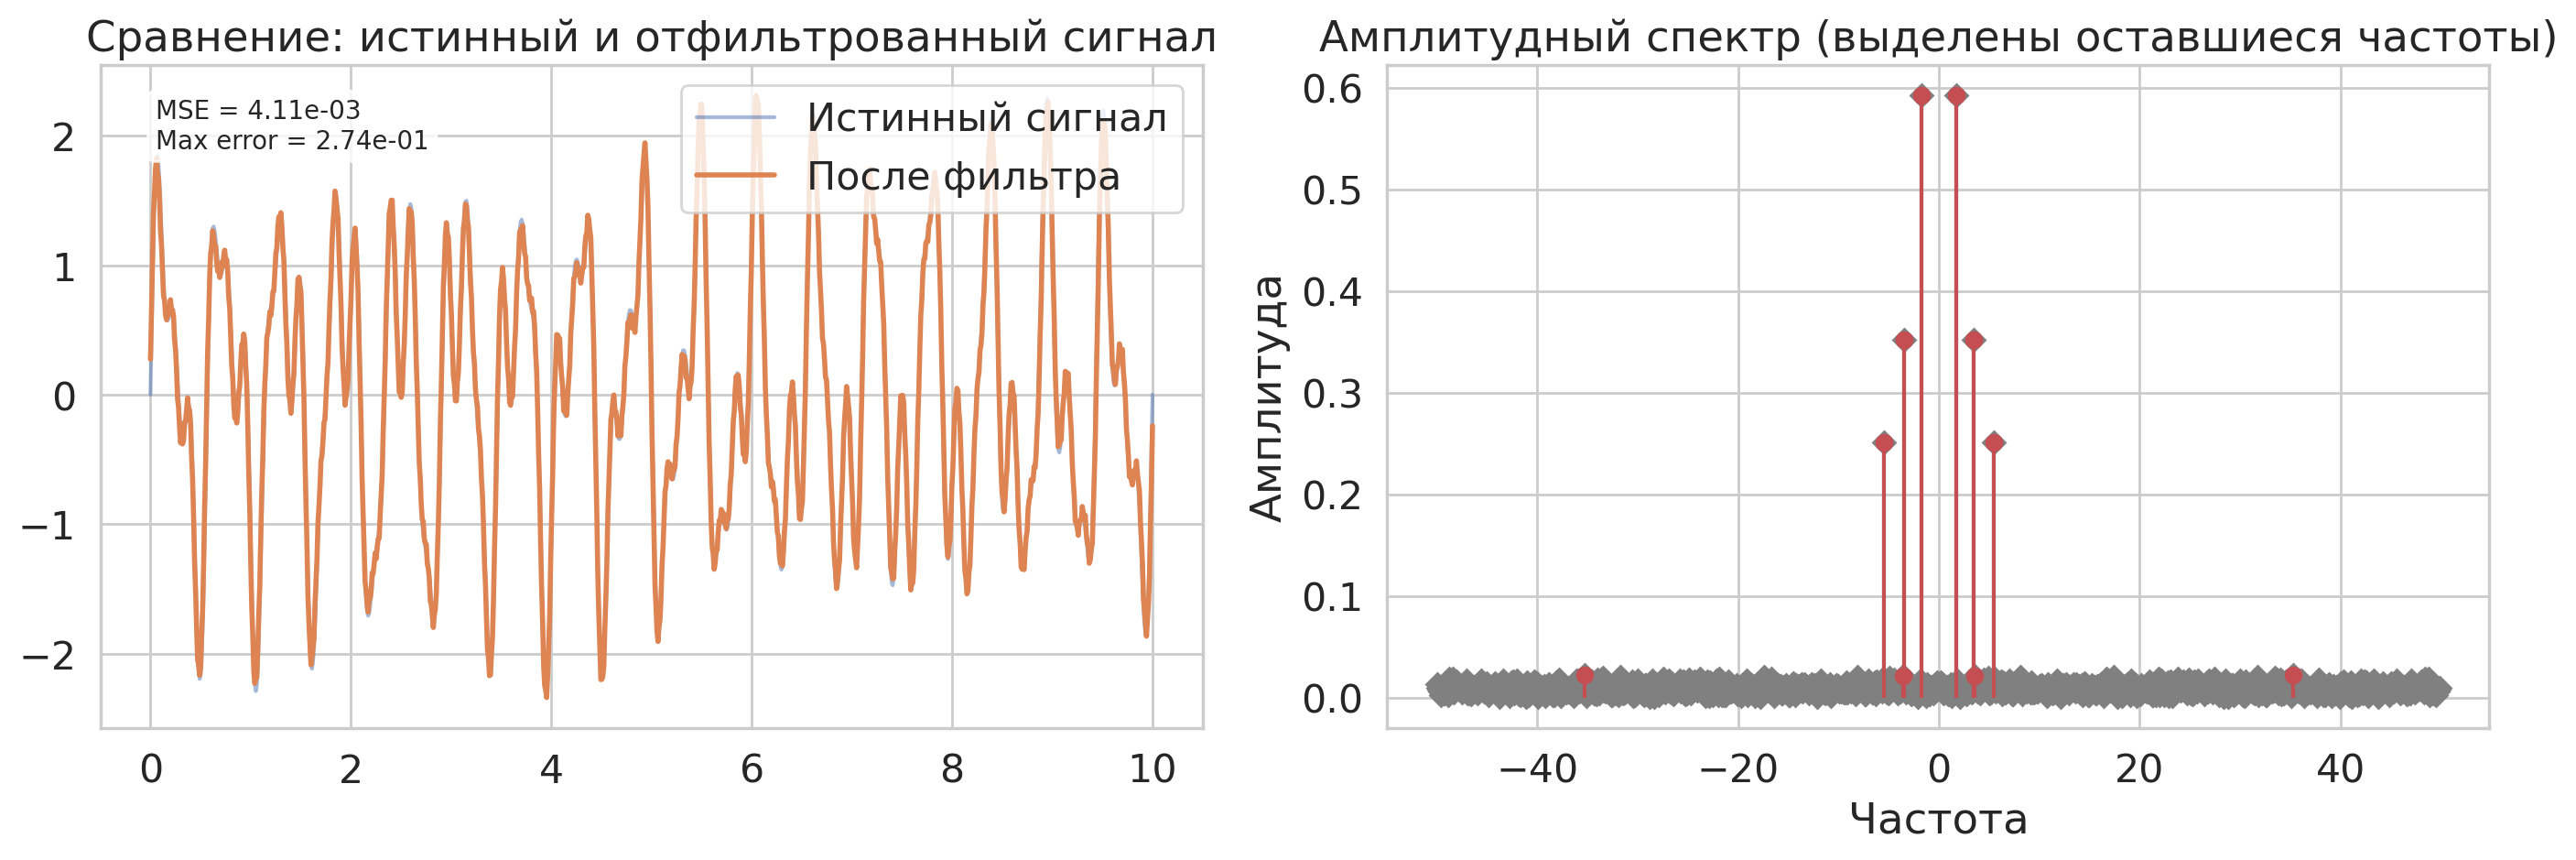

In [228]:
N = 1000
T_total = 10  # секунд
t = np.linspace(0, T_total, N)
dt = t[1] - t[0]
T = 1.0

x_clean = (
    1.2 * np.sin(2 * np.pi * 1.7 * t) +
    0.7 * np.sin(2 * np.pi * 3.5 * t) +
    0.5 * np.sin(2 * np.pi * 5.5 * t)
)

noise = 0.3 * np.random.randn(N)
x_noisy = x_clean + noise

X = DFT(x_noisy)
plot_fourier_spectra(x_noisy, X, N=N, period=T_total, plot_sin_cos=False, figsize=(14, 5))

filter = SignalFilter(mode="topk", top_k=10)
x_filtered = filter.fit_transform(t, x_noisy)

filter.plot_spectra_comparison(t, x_filtered=x_filtered, x_true=x_clean, figsize=(14, 5))
plt.show()

#### Фильтрация на реальных данных

In [219]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


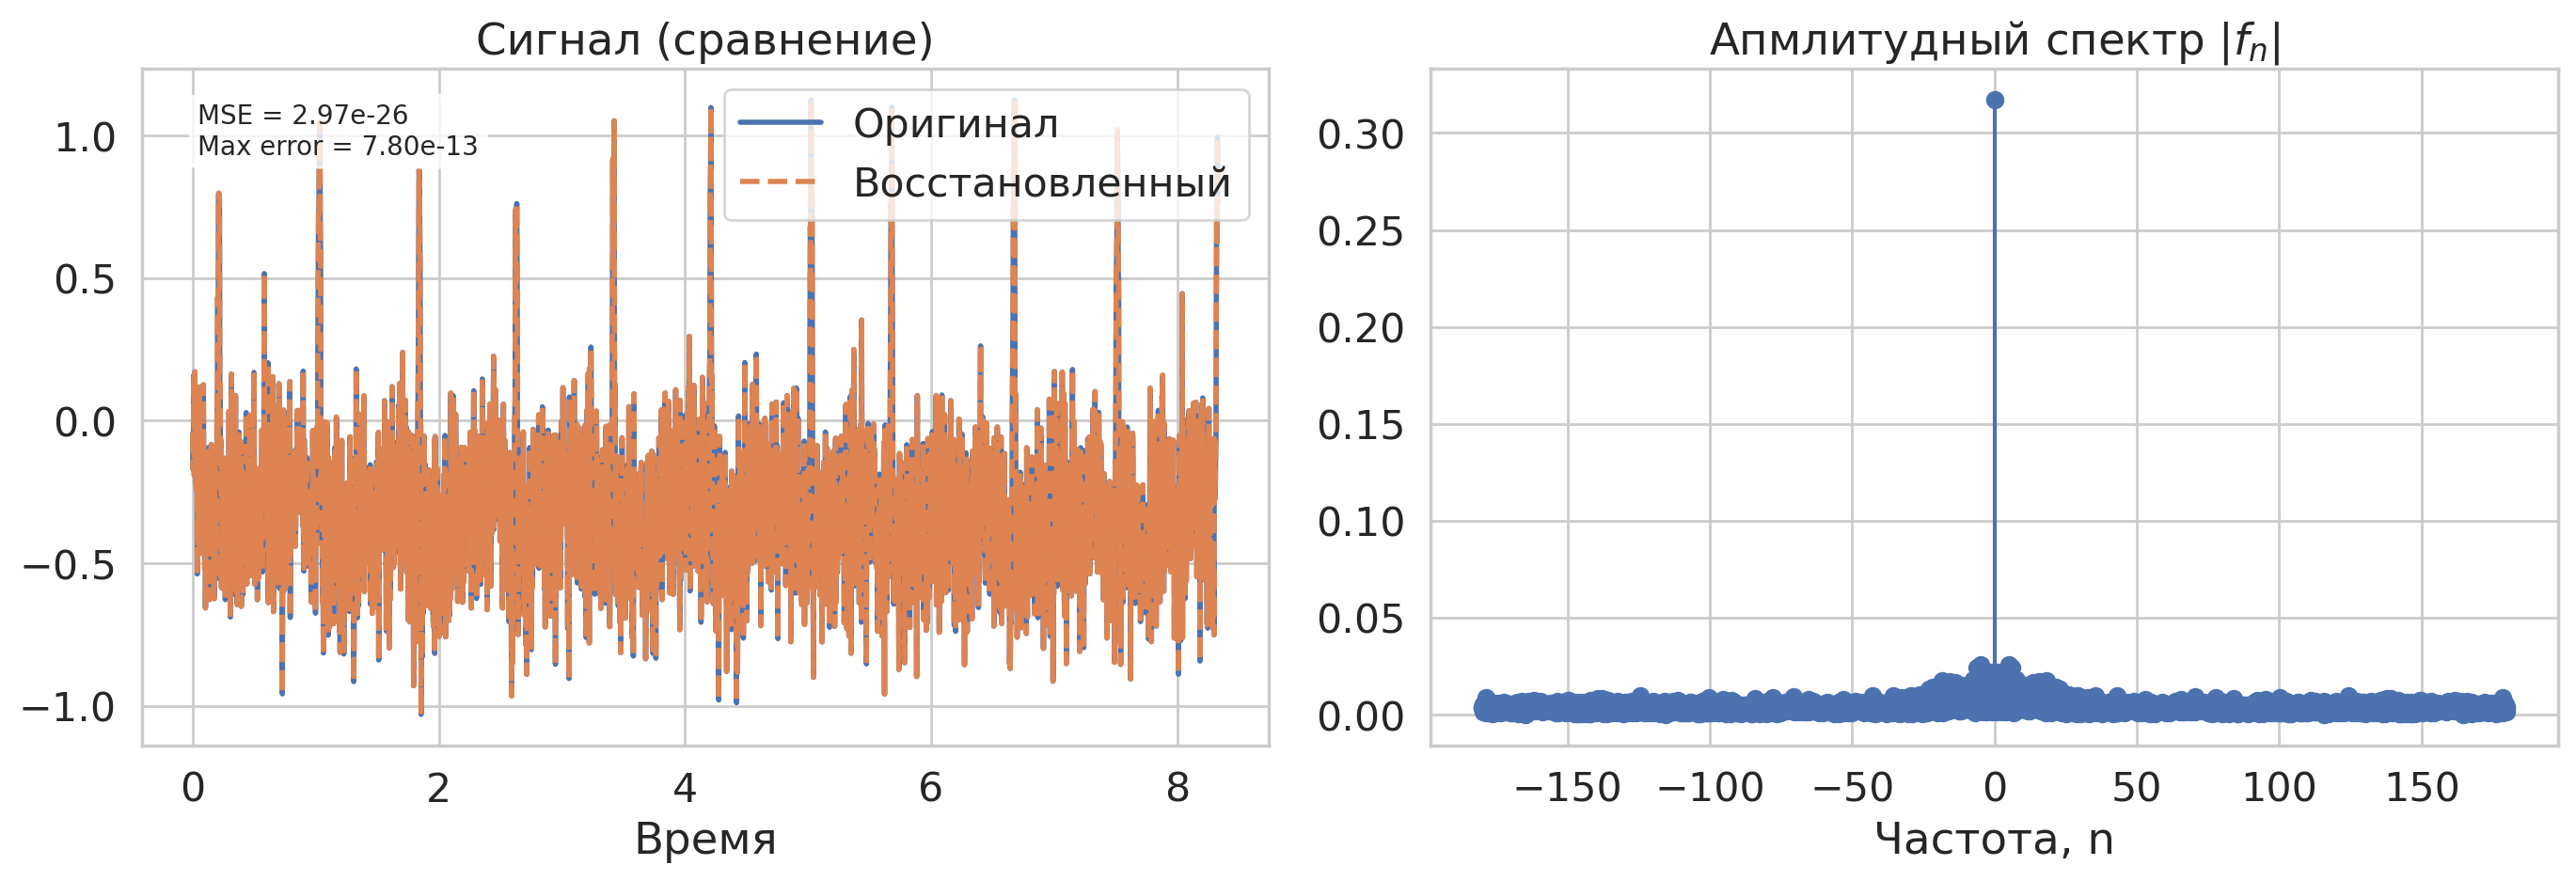

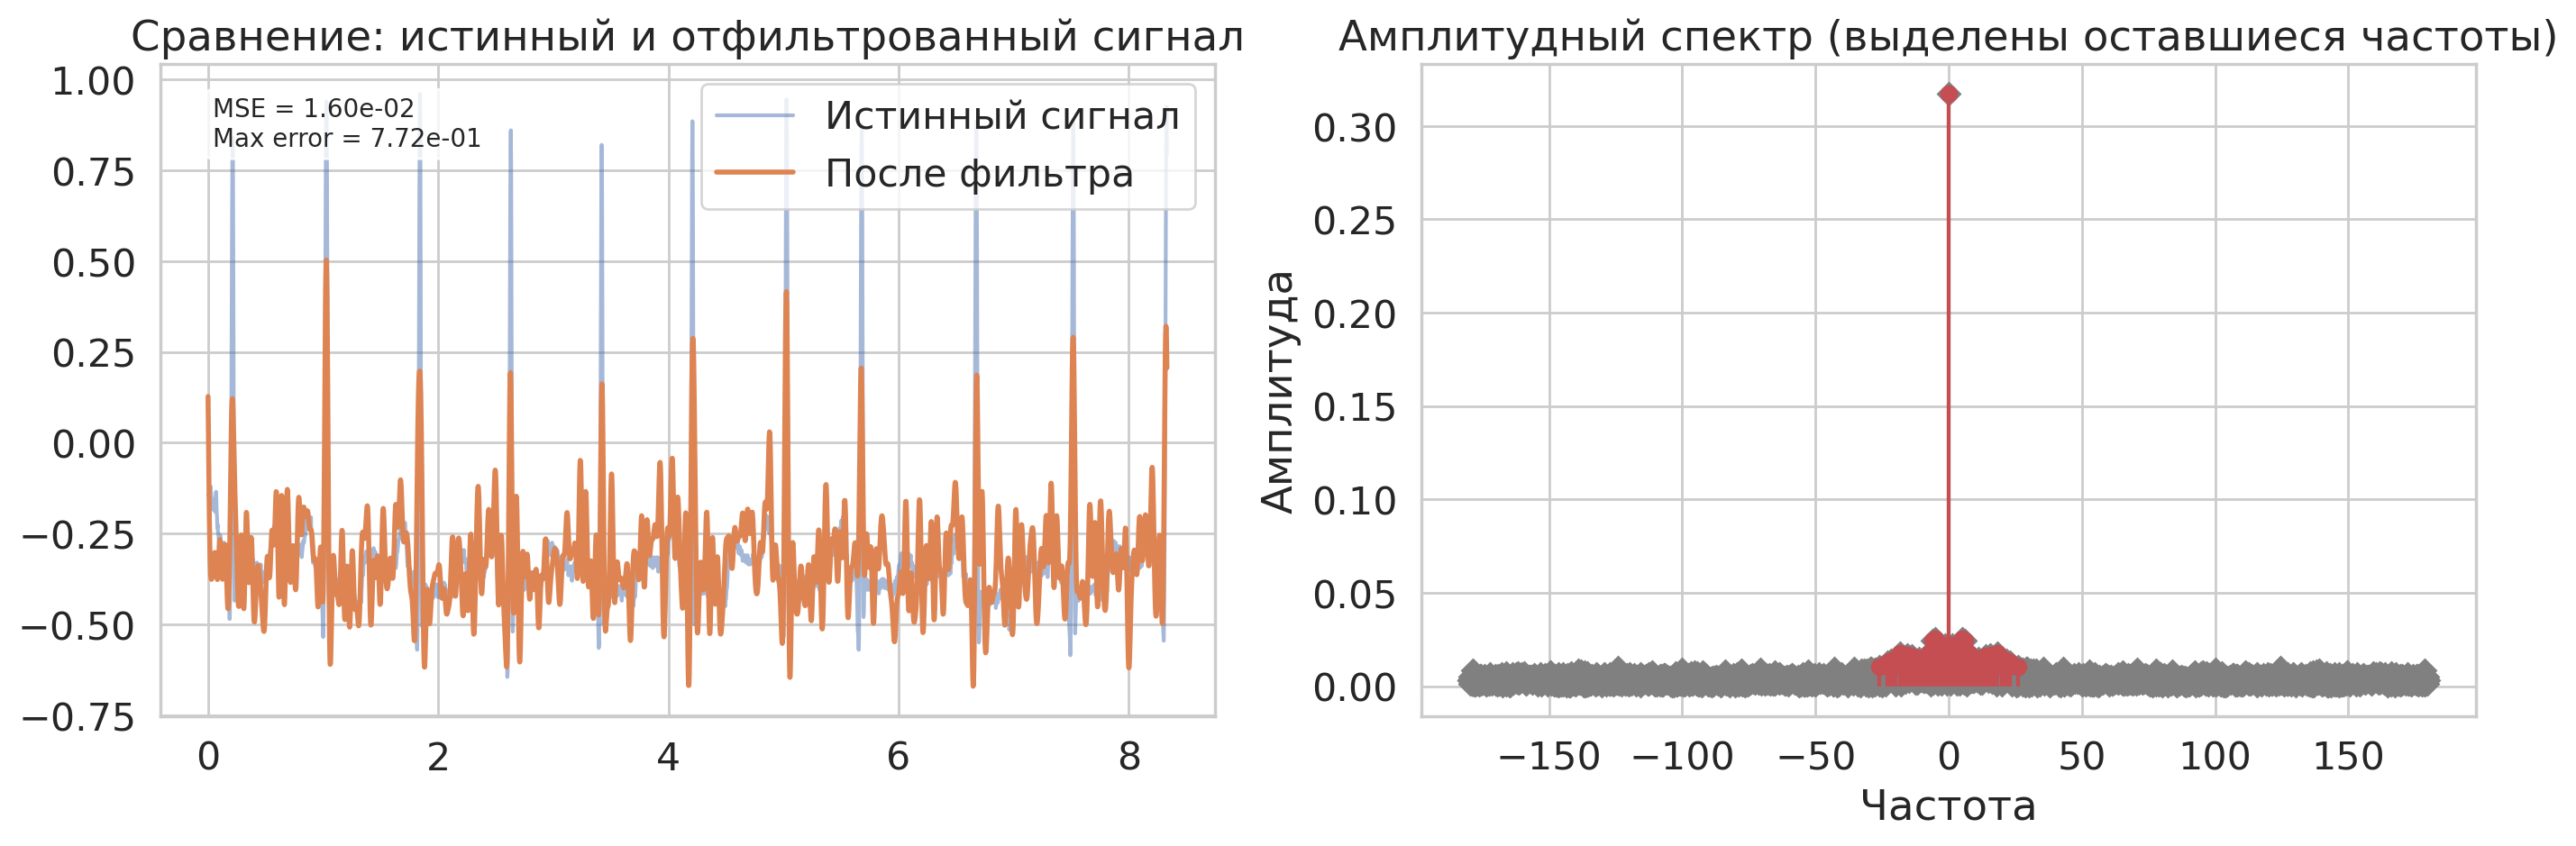

In [230]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# === Загрузка сигнала из PhysioNet ===
# Например, MIT-BIH record "100" (есть по умолчанию)
record = wfdb.rdrecord('100', pn_dir='mitdb', sampto=3000)  # 3000 отсчётов
x_clean = record.p_signal[:, 0]  # Первый канал (обычно MLII)
fs = record.fs  # Частота дискретизации, обычно 360 Гц
t = np.arange(len(x_clean)) / fs

# Добавим шум для теста фильтра
np.random.seed(42)
x_noisy = x_clean + 0.2 * np.random.randn(len(x_clean))

# === Спектр до фильтрации ===
X = DFT(x_noisy)
plot_fourier_spectra(x_noisy, X, N=len(x_noisy), period=t[-1] - t[0], plot_sin_cos=False, figsize=(14, 5))

# === Применение фильтра ===
filter = SignalFilter(mode="topk", top_k=100)
x_filtered = filter.fit_transform(t, x_noisy)

# === Сравнение с оригиналом ===
filter.plot_spectra_comparison(t, x_filtered=x_filtered, x_true=x_clean, figsize=(14, 5))
plt.show()


### Оценка качества функции: численные своойства

**Оценку качества будем делать таким методом**: восстановим функцию по более плотной сетке при помощи вычисления ряда Фурье и оценим ошибку по отношению к исходной функции

In [ ]:
def fourier_coef(y, N_terms=None, fft=DFT, warning=True):
    """Вычисляет коэффициенты ряда Фурье для функции"""
    N = len(y)
    if N_terms is None:
        N_terms = N//3
    if N_terms >= N//2 and warning:
        # Максимум по теореме Котельникова
        print("Aliasing problem")

    fft_coeffs = fft(y) / N

    a0 = 2 * fft_coeffs[0].real
    an = 2 * fft_coeffs[1:N_terms+1].real
    bn = -2 * fft_coeffs[1:N_terms+1].imag

    return a0, an, bn


def fourier_reconstruct(x, a0, an, bn, a, b):
    """Восстанавливает сигнал по коэффициентам Фурье для интервала длины period"""
    x -= a
    x *= 1/(b-a)

    result = a0/2
    for i in range(len(an)):
        n = i+1

        omega = 2*np.pi*n
        result += an[i]*np.cos(a+omega*x) + bn[i]*np.sin(a+omega*x)
    return result

#### Рассмотрим убывание ошибки с ростом частоты дискретизации.

In [ ]:
def calc_fourier_reconstruct_error(func, a, b, N, M, N_terms=None, plot=False, warning=True):
    _, y = func_discretization(func, a, b, N)

    a0, an, bn = fourier_coef(y, N_terms, warning=warning)

    x = time_discretization(a, b, M)
    y_reconstruct = fourier_reconstruct(x, a0, an, bn, a, b)

    if plot:
        print(a, b)
        plt.plot(x, func(x), label="true")
        plt.plot(x, y_reconstruct, label="fourier_reconstruct")

    return np.mean((y_reconstruct - func(x))**2)

SyntaxError: invalid syntax (<ipython-input-194-448619d4d43c>, line 9)

In [ ]:
n_range = np.arange(10, 10**3+1, 10)

mse = [
    calc_fourier_reconstruct_error(lambda x: np.exp(x) + np.exp(1-x), 0, 1, n, 10**4)
    for n in tqdm(n_range)
]

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Визуализация

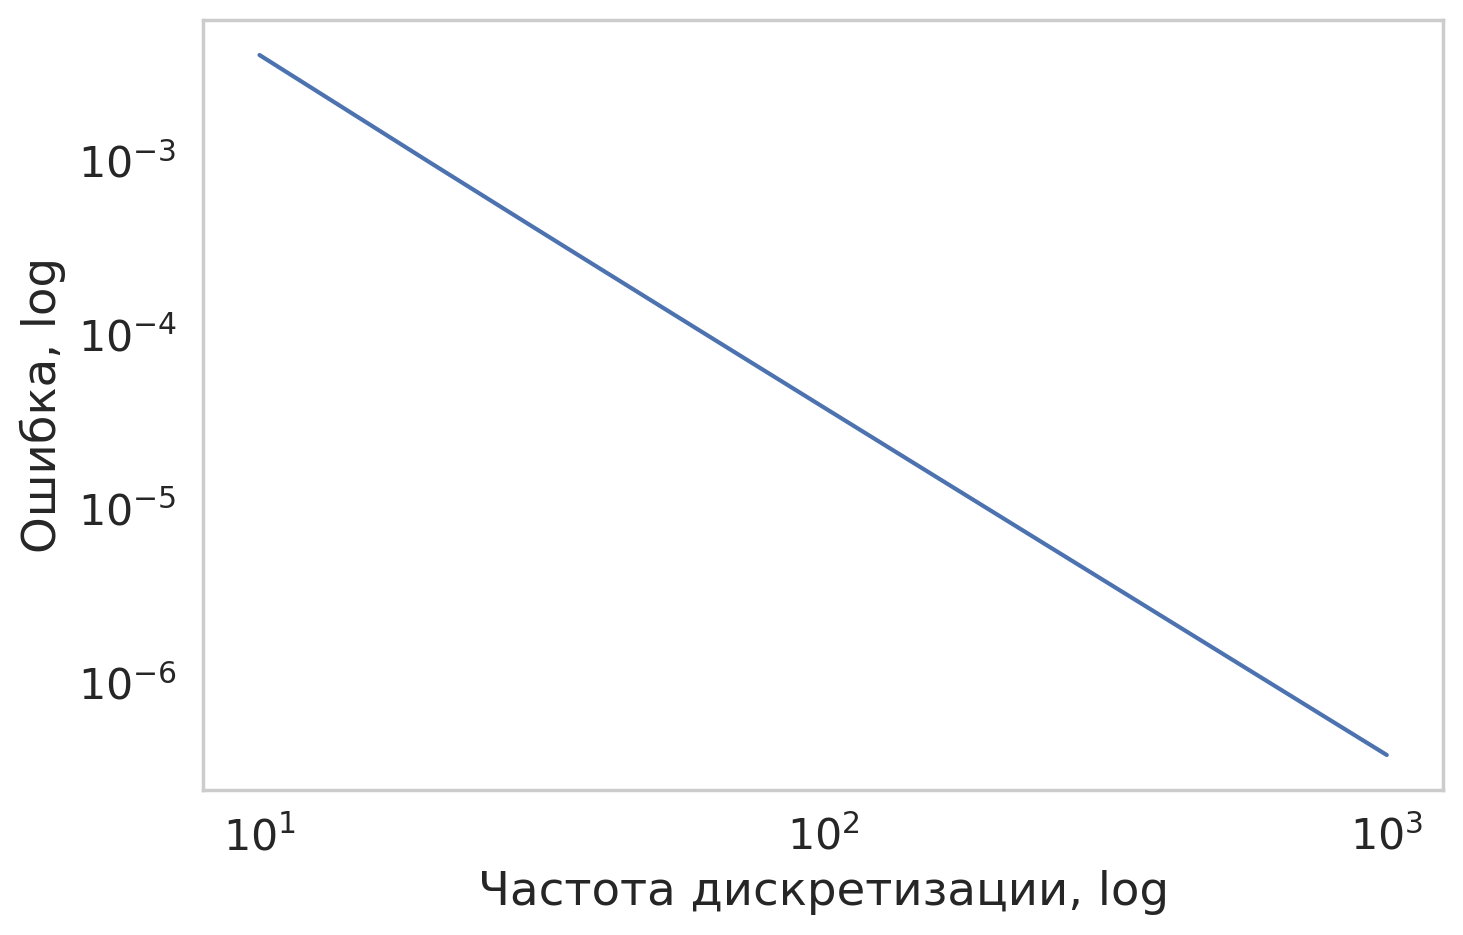

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(n_range, mse)

plt.ylabel("Ошибка, log")
plt.xlabel("Частота дискретизации, log")

plt.xscale("log")
plt.yscale("log")

plt.grid(False)
plt.show()

### Оценка качества функции: временная эффективность

In [ ]:
t = []
n_range = np.linspace(10**2, 10**4, 100)

for n in tqdm(n_range):
    start = time.time()
    DFT(np.exp(time_discretization(0, 1, n)))
    t.append(time.time() - start)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
plt.plot(n_range, t)
plt.show()

In [ ]:
t = []
n_range = np.linspace(10**2, 10**4, 10**4)

for n in tqdm(n_range):
    start = time.time()
    spf.fft(np.exp(time_discretization(0, 1, n)))
    t.append(time.time() - start)

  0%|          | 0/10000 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object cannot be interpreted as an integer

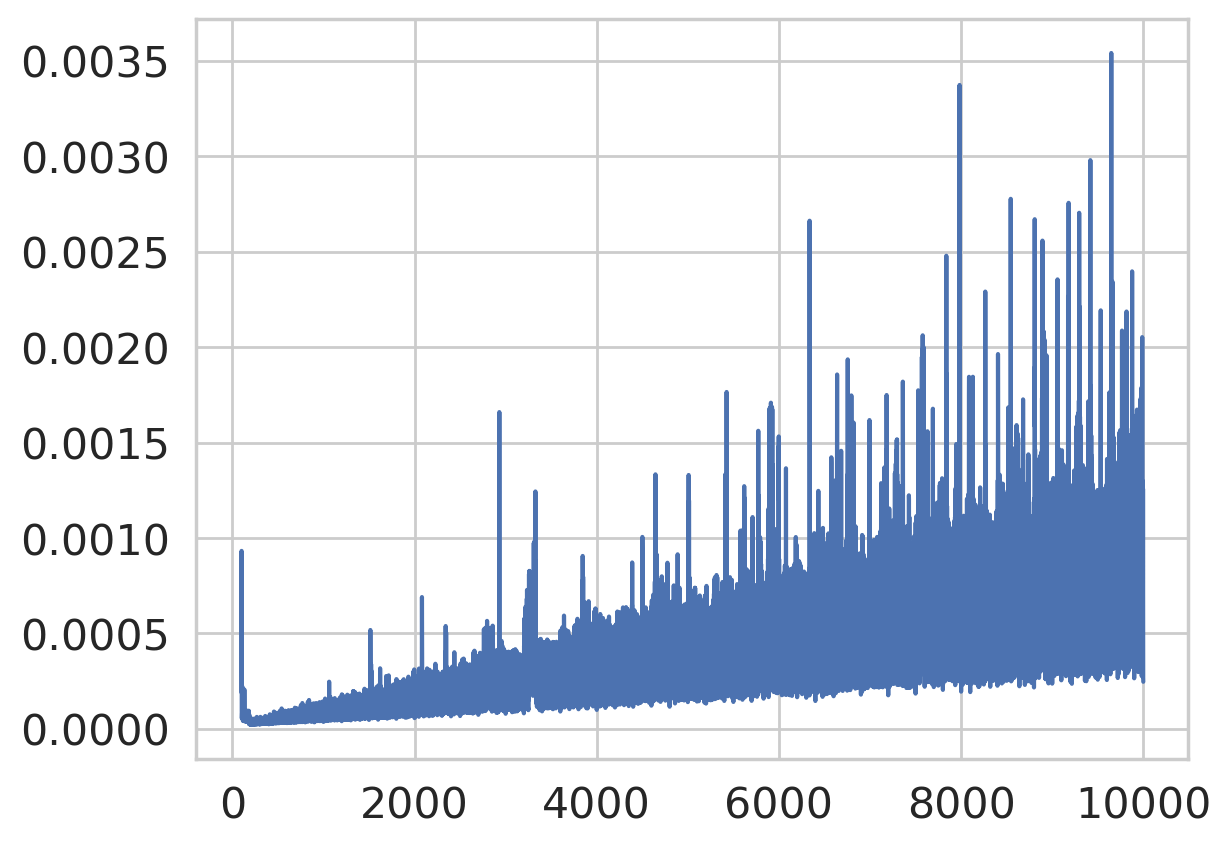

In [ ]:
plt.plot(n_range, t)
plt.show()

## Эффект алиасинга и численная проверка теоремы Котельникова

### Эффект алиасинга

> Эффект алиасинга (или наложение частот) - это искажение сигнала, возникающее при неправильной дискретизации, когда частота дискретизации (количество отсчетов в секунду) недостаточна для точного представления высокочастотных компонентов сигнала. Это приводит к тому, что высокие частоты "маскируются" под низкие, создавая ложные артефакты.

_Chat GPT_


In [ ]:
Fs = 10  # Частота дискретизации (Гц)
t = time_discretization(0, 10, Fs)

y1 = lambda x: np.sin(2*np.pi*x)
y2 = lambda x: np.sin(2*np.pi*x*0.1)

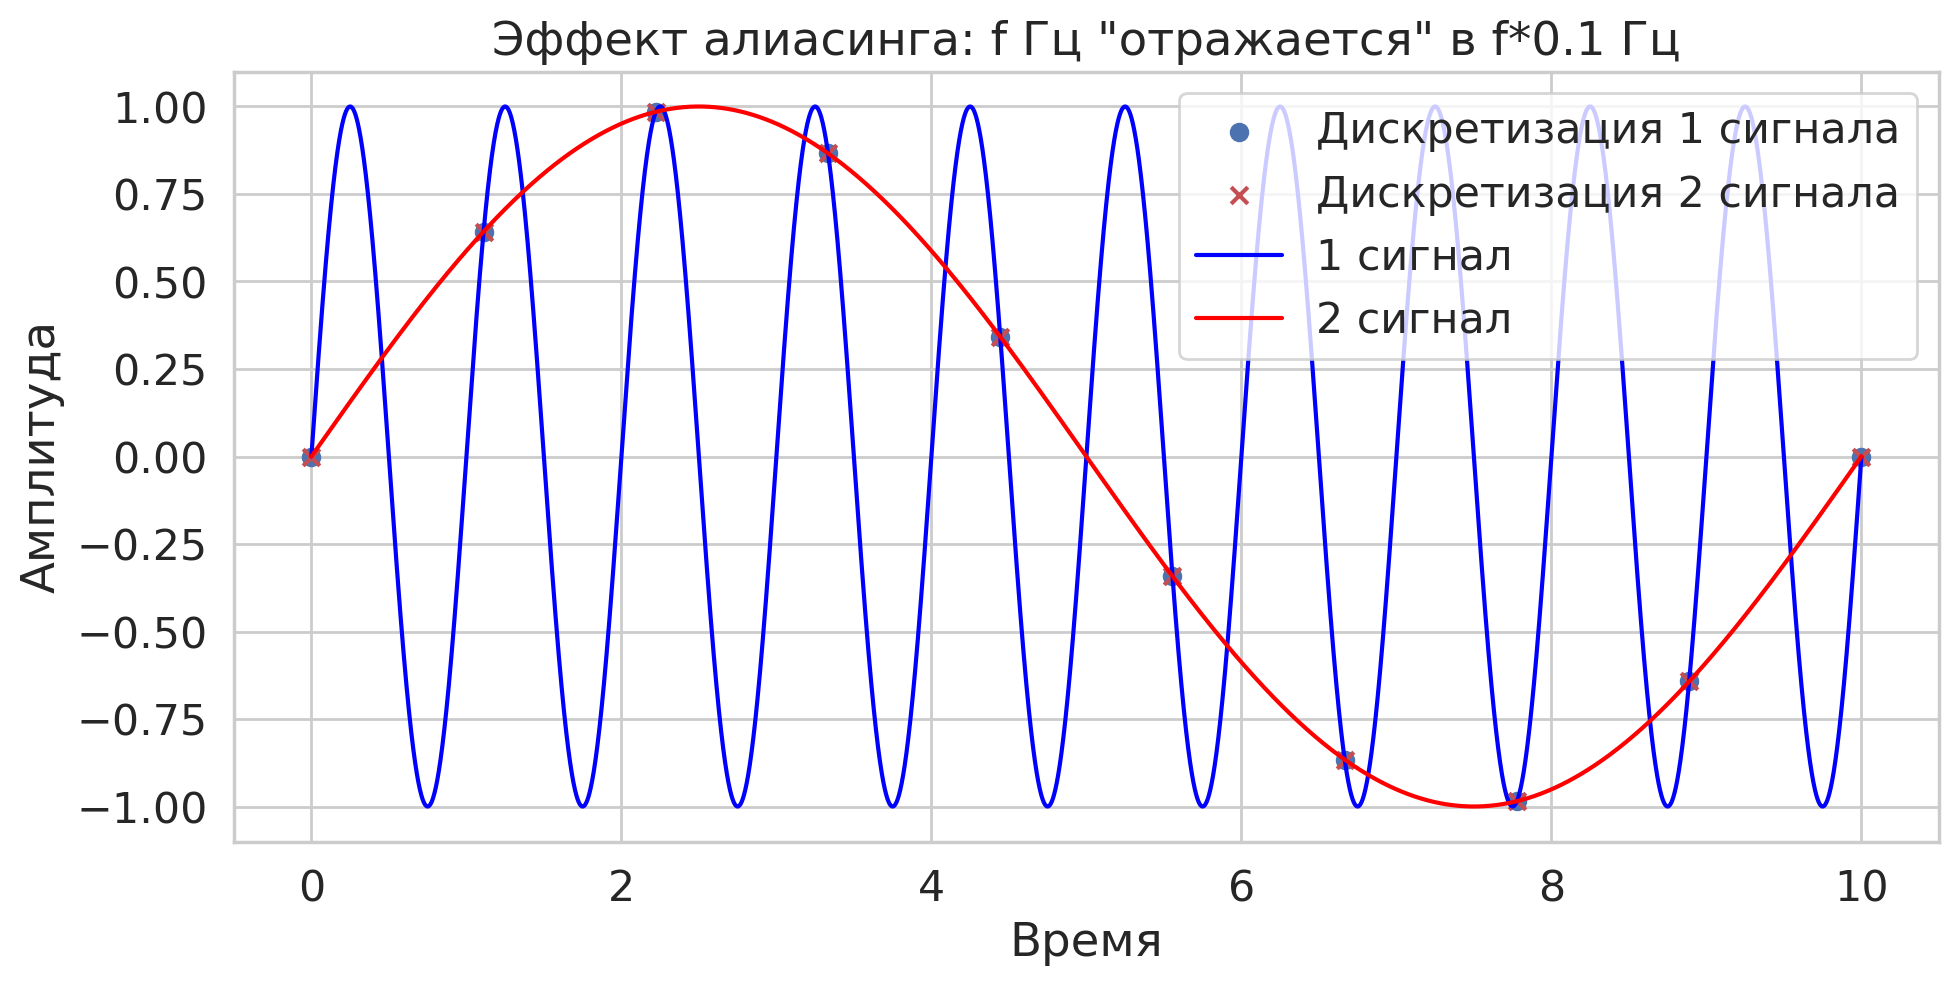

In [ ]:
plt.figure(figsize=(11, 5))

plt.scatter(t, y1(t), color='b', marker="o", label="Дискретизация 1 сигнала")
plt.scatter(t, y2(t), color='r', marker="x", label="Дискретизация 2 сигнала")

x = time_discretization(0, 10, 10**4)

plt.plot(x, y1(x), color='blue', label="1 сигнал")
plt.plot(x, y2(x), color='red', label="2 сигнал")

plt.title('Эффект алиасинга: f Гц "отражается" в f*0.1 Гц')
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.legend()
plt.grid(True)
plt.show()

### Проверка теоремы Котельникова

__Теорема Котельникова (Найквиста-Шеннона)__

Чтобы точно восстановить сигнал, частота дискретизации должна быть как минимум в 2 раза выше максимальной частоты в спектре сигнала:
$$    F_s > 2F_{max​} $$

In [ ]:
f_range = np.arange(10, 100)

mse = [
    calc_fourier_reconstruct_error(lambda x: np.sin(2 * np.pi * f * x), 0, 0.1, 100, 10**4)
    for f in tqdm(f_range)
]

100%|██████████| 90/90 [00:14<00:00,  6.20it/s]


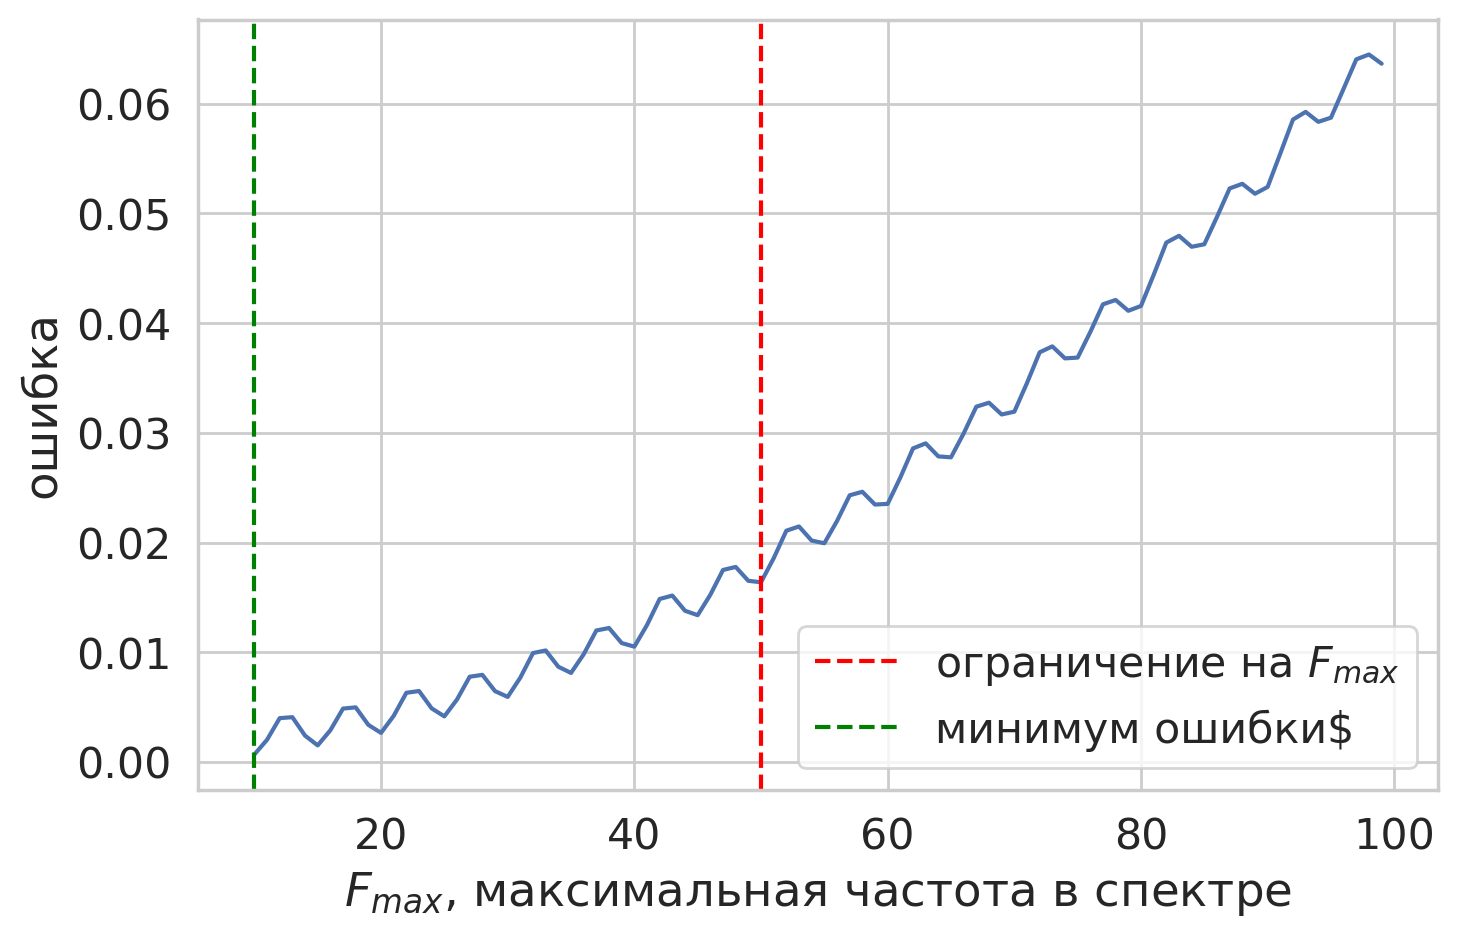

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(f_range, mse)

plt.axvline(x=100//2, color="red", linestyle="--", label=r"ограничение на $F_{max}$")
plt.axvline(x=n_range[np.argmin(mse)], color="green", linestyle="--", label=r"минимум ошибки$")

plt.ylabel("ошибка")
plt.xlabel(r"$F_{max}$, максимальная частота в спектре")

# plt.grid(False)
plt.legend()
plt.show()

**Еще одна илюстрация**.

In [ ]:
N = 1000
n_range = np.arange(10, N, 10)

error = [
    calc_fourier_reconstruct_error(lambda x: np.exp(x)+np.exp(1-x), 0, 1, N, 10**4, N_terms=n)
    for n in n_range
]

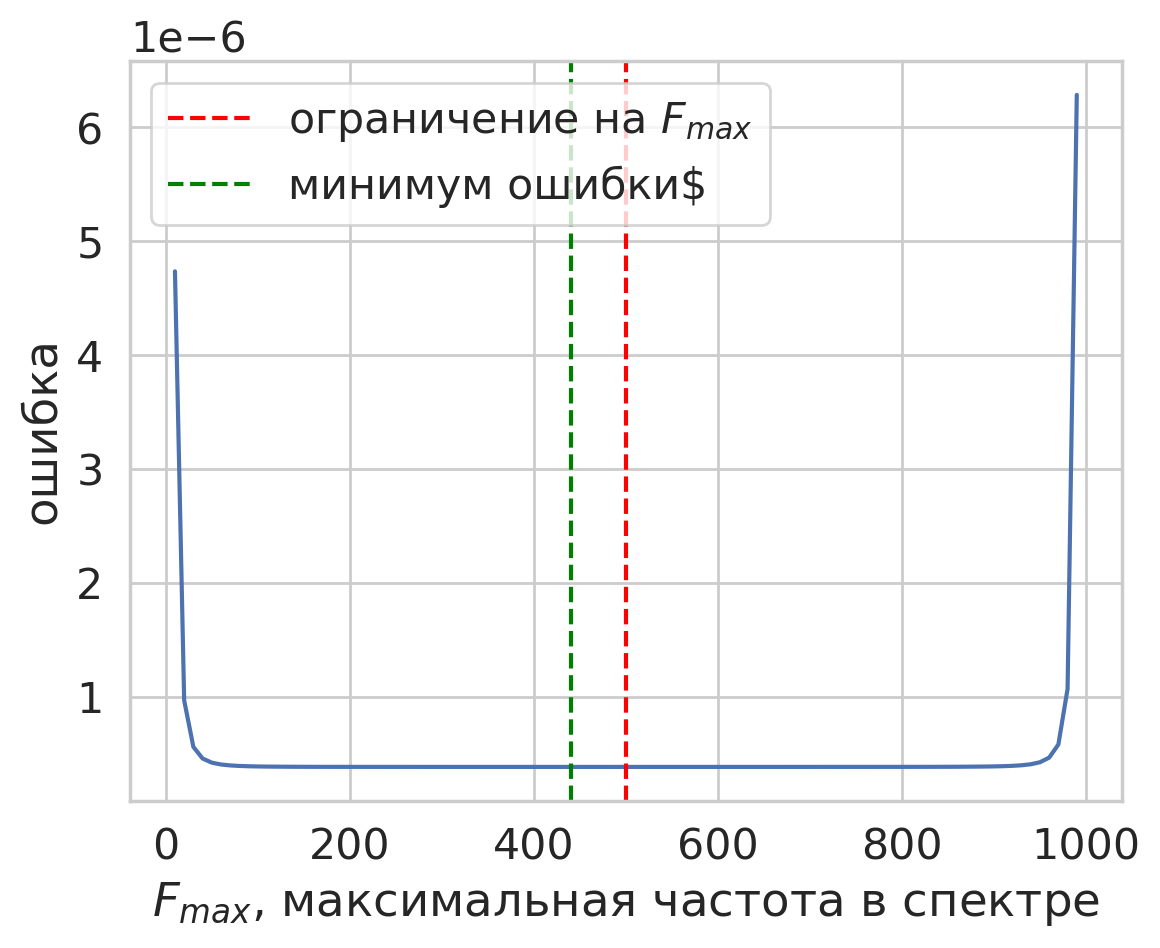

In [ ]:
plt.plot(n_range, error)

plt.axvline(x=N//2, color="red", linestyle="--", label=r"ограничение на $F_{max}$")
plt.axvline(x=n_range[np.argmin(error)], color="green", linestyle="--", label=r"минимум ошибки$")

plt.ylabel("ошибка")
plt.xlabel(r"$F_{max}$, максимальная частота в спектре")

plt.legend()
plt.show()

## Вейвлет преобразование для функции Хаара

## Интеграл от быстроосциллирующих функций